#### Problem Statement

Project Title:
“Optimizing E-Commerce Strategy with Customer Segmentation and Predictive Analytics”
________________________________________


E-commerce businesses need to improve customer retention, boost sales, and personalize marketing. However, without data-driven insights, decisions are often reactive and inefficient.
This project aims to:

1.	Segment customers based on purchase behavior and demographics
2.	Predict future purchases or churn risk using machine learning
3.	Provide actionable business insights to improve marketing and product strategies


**Stakeholders**

|Stakeholder              | What they care About
|-------------------------|------------------------
|Marketing Team           |Improve campaign efficiency and ROI; avoid over-contacting customers|
Data Science Team         |Build interpretable, reliable models with business impact
Compliance/Legal          |Ensure targeting practices are fair, non-discriminatory
Sales / Call Center       |Focus effort on the right customers; increase success rates
Senior Management         |Strategic insights on customer behavior and product interest




Reference

https://loyaltylion.com/blog/customer-retention-rate

#### Imports

Import the required libraries

In [304]:
import pandas as pd
import zipfile
import urllib.request
import io
import os
from google.cloud import bigquery

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample


### Loading dataset

Dataset is from Google [Big Query](https://console.cloud.google.com/bigquery?ws=!1m4!1m3!3m2!1sbigquery-public-data!2sthelook_ecommerce).
A function was writen to obtain the tables in the dataset. The ecommerce data has `7` tables namely:  "distribution_centers", "events", "inventory_items", "order_items", "orders", "products", "users".

In [305]:

client = bigquery.Client(project="testing-469722")

def load_thelook_tables(dataset_id="bigquery-public-data.thelook_ecommerce", table_names=None):
    """
    Load multiple tables from thelook_ecommerce dataset into separate DataFrames.

    Parameters:
        dataset_id (str): Full BigQuery dataset path
        table_names (list): List of table names to load

    Returns:
        dict: Dictionary of {table_name: DataFrame}
    """
    if table_names is None:
        table_names = [
            "distribution_centers",
            "events",
            "inventory_items",
            "order_items",
            "orders",
            "products",
            "users"
        ]

    dataframes = {}

    for table in table_names:
        query = f"SELECT * FROM `{dataset_id}.{table}`"
        df = client.query(query).to_dataframe()
        dataframes[table] = df
        print(f"Loaded {table}: {df.shape[0]} rows")

    return dataframes

### Load the dataset

The dataset are pulled from Big query.


In [306]:
thelook_dfs = load_thelook_tables()

C:\Users\DELL XPS\virtual\dsb_602\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded distribution_centers: 10 rows
Loaded events: 2419545 rows
Loaded inventory_items: 487962 rows
Loaded order_items: 180761 rows
Loaded orders: 124774 rows
Loaded products: 29120 rows
Loaded users: 100000 rows


### Accessing the tables


In [307]:
# order table

orders_df = thelook_dfs['orders']
orders_df.head(4)

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,5,5,Cancelled,F,2025-06-27 01:52:00+00:00,NaT,NaT,NaT,1
1,19,22,Cancelled,F,2023-02-24 10:55:00+00:00,NaT,NaT,NaT,1
2,26,30,Cancelled,F,2022-01-10 07:12:00+00:00,NaT,NaT,NaT,1
3,27,31,Cancelled,F,2025-06-18 15:07:00+00:00,NaT,NaT,NaT,3


**orders_df table dictionary**

| Column Name    | Description                                                           |
| -------------- | --------------------------------------------------------------------- |
| `order_id`     | Unique identifier for each order                                      |
| `user_id`      | Foreign key that links to the customer (`users.id`)                   |
| `status`       | Status of the order (e.g., `Complete`, `Returned`, `Cancelled`)       |
| `gender`       | Gender of the customer (from the `users` table, if joined)            |
| `created_at`   | Timestamp when the order was placed                                   |
| `returned_at`  | Timestamp when the item was returned (null if not returned)           |
| `shipped_at`   | Timestamp when the item was shipped                                   |
| `delivered_at` | Timestamp when the item was delivered to the customer                 |
| `num_of_item`  | Number of individual items in that order (usually from `order_items`) |


In [308]:
# distribution_centers

distribution_df = thelook_dfs['distribution_centers']
distribution_df.head(5)

,id,name,latitude,longitude,distribution_center_geom
0,6,Port Authority of New York/New Jersey NY/NJ,40.6340,-73.7834,POINT(-73.7834 40.634)
1,3,Houston TX,29.7604,-95.3698,POINT(-95.3698 29.7604)
2,7,Philadelphia PA,39.9500,-75.1667,POINT(-75.1667 39.95)
3,5,New Orleans LA,29.9500,-90.0667,POINT(-90.0667 29.95)
4,9,Charleston SC,32.7833,-79.9333,POINT(-79.9333 32.7833)


**distribution_df dictionary**

| Column Name                | Description                                                                 |
| -------------------------- | --------------------------------------------------------------------------- |
| `id`                       | Unique identifier for each distribution center                              |
| `name`                     | City and state abbreviation of the distribution center location             |
| `latitude`                 | Latitude coordinate of the distribution center (for mapping or distance)    |
| `longitude`                | Longitude coordinate of the distribution center                             |
| `distribution_center_geom` | Geometry field representing the center as a geographic point (GeoJSON-like) |


In [309]:
events_df = thelook_dfs['events']
events_df.head(5)

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1761683,<NA>,3,3f3cb421-4e4e-49f4-9535-0f8d23c99840,2022-06-23 06:28:00+00:00,90.127.223.161,São Paulo,São Paulo,02675-031,Safari,Email,/cancel,cancel
1,1494059,<NA>,3,65625637-f520-4c15-9f86-e71adc817481,2025-07-05 12:10:00+00:00,44.48.189.170,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
2,2402072,<NA>,3,ce1188d5-c68e-4220-bd90-1deaffc75e68,2022-06-05 15:29:00+00:00,30.192.149.44,São Paulo,São Paulo,02675-031,Chrome,Organic,/cancel,cancel
3,2395341,<NA>,3,687907e2-9f6c-4acf-b67d-51d73212bc0a,2019-03-11 07:46:00+00:00,219.39.13.103,São Paulo,São Paulo,02675-031,Firefox,Email,/cancel,cancel
4,1298942,<NA>,3,1694eb1f-cf5d-4120-8052-6e28a162943f,2023-09-07 18:19:00+00:00,34.56.62.7,São Paulo,São Paulo,02675-031,Firefox,Facebook,/cancel,cancel


**events_df dictionary**

| Column Name       | Description                                                           |
| ----------------- | --------------------------------------------------------------------- |
| `id`              | Unique identifier for each event record                               |
| `user_id`         | ID of the user associated with the event *(can be missing/anonymous)* |
| `sequence_number` | Order of the event within a session (helps track user journey)        |
| `session_id`      | Unique ID for the user session (used to group related events)         |
| `created_at`      | Timestamp when the event occurred                                     |
| `ip_address`      | User’s IP address at the time of the event                            |
| `city`            | City of the user (inferred from IP)                                   |
| `state`           | State of the user (inferred from IP)                                  |
| `postal_code`     | Postal code of the user (inferred from IP)                            |
| `browser`         | Browser used by the user (e.g., Chrome, Safari)                       |
| `traffic_source`  | Source that led the user to the site (e.g., Organic, Email, Adwords)  |
| `uri`             | Specific page or endpoint visited (e.g., `/cancel`)                   |
| `event_type`      | Type of user action or event (e.g., `cancel`, `purchase`, `checkout`) |


In [310]:
inventoryitems_df = thelook_dfs['inventory_items']
inventoryitems_df.head()

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,551,13844,2021-05-19 01:40:43+00:00,2021-06-28 08:10:43+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,552,13844,2020-02-27 18:59:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,553,13844,2021-10-14 09:13:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,554,13844,2021-12-04 01:18:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,22762,13844,2024-10-23 04:49:03+00:00,2024-11-27 23:00:03+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


**inventoryitems_df dictionary**

| Column Name                      | Description                                                                                                 |
| -------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| `id`                             | Unique identifier for each inventory record                                                                 |
| `product_id`                     | ID of the product listed in the inventory                                                                   |
| `created_at`                     | Timestamp when the product was added to inventory                                                           |
| `sold_at`                        | Timestamp when the product was sold (null if unsold)                                                        |
| `cost`                           | Cost to the business for this unit (wholesale price)                                                        |
| `product_category`               | Category label for the product (e.g., *Jumpsuits & Rompers*)                                                |
| `product_name`                   | Full name or title of the product                                                                           |
| `product_brand`                  | Brand/manufacturer of the product                                                                           |
| `product_retail_price`           | Suggested retail price or sale price to customer                                                            |
| `product_department`             | Department the product belongs to (e.g., *Women*)                                                           |
| `product_sku`                    | Unique stock keeping unit (SKU) for inventory tracking                                                      |
| `product_distribution_center_id` | Foreign key linking to the distribution center where the item is stocked (join with `distribution_centers`) |


In [311]:
orderitems_df = thelook_dfs['order_items']
orderitems_df.head(5)

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,113201,78187,62744,14235,305557,Processing,2025-06-18 23:59:09+00:00,NaT,NaT,NaT,0.02
1,1228,858,727,14235,3351,Shipped,2025-03-03 01:04:35+00:00,2025-03-05 18:47:00+00:00,NaT,NaT,0.02
2,23652,16290,13039,14235,63924,Shipped,2024-02-21 01:07:51+00:00,2024-02-21 09:06:00+00:00,NaT,NaT,0.02
3,31610,21788,17441,14235,85377,Shipped,2024-12-12 07:47:05+00:00,2024-12-10 05:39:00+00:00,NaT,NaT,0.02
4,169620,117065,93832,14159,457790,Cancelled,2023-08-19 03:11:37+00:00,NaT,NaT,NaT,0.49


**orderitems_df**

| Column Name         | Description                                                                    |
| ------------------- | ------------------------------------------------------------------------------ |
| `id`                | Unique identifier for each order item (line item)                              |
| `order_id`          | Foreign key referencing the `orders` table (represents the main order)         |
| `user_id`           | ID of the customer who placed the order                                        |
| `product_id`        | ID of the product ordered (from `products` or `inventories` table)             |
| `inventory_item_id` | Foreign key linking to the specific item in the inventory (from `inventories`) |
| `status`            | Status of the item within the order: `Complete`, `Cancelled`, etc.             |
| `created_at`        | Timestamp when the item was added to the order                                 |
| `shipped_at`        | Timestamp when the item was shipped                                            |
| `delivered_at`      | Timestamp when the item was delivered                                          |
| `returned_at`       | Timestamp if the item was returned                                             |
| `sale_price`        | Price at which the item was sold to the customer                               |


In [312]:
products_df = thelook_dfs['products']
products_df.head(5)

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


**products_df**

| Column Name              | Description                                                                                                      |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------- |
| `id`                     | Unique product ID                                                                                                |
| `cost`                   | Internal cost of the product for the retailer                                                                    |
| `category`               | Product category (e.g., Accessories, Tops, Shoes)                                                                |
| `name`                   | Full name or description of the product                                                                          |
| `brand`                  | Brand or manufacturer of the product                                                                             |
| `retail_price`           | Recommended retail price for the product                                                                         |
| `department`             | Department the product belongs to (e.g., Women, Men, Kids)                                                       |
| `sku`                    | Stock Keeping Unit: unique code used to identify and track inventory                                             |
| `distribution_center_id` | Foreign key linking to the `distribution_centers` table, indicating where the product is stocked or shipped from |


In [313]:
users_df = thelook_dfs['users']
users_df.head(5)

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at,user_geom
0,35619,Christopher,Thompson,christopherthompson@example.net,19,M,Acre,188 Michael Village,69980-000,null,Brasil,-8.065346,-72.870949,Email,2021-10-09 14:07:00+00:00,POINT(-72.87094866 -8.065346116)
1,67067,Sarah,Reed,sarahreed@example.org,61,F,Acre,417 Christopher Manors,69980-000,null,Brasil,-8.065346,-72.870949,Search,2022-05-06 00:00:00+00:00,POINT(-72.87094866 -8.065346116)
2,56242,Elizabeth,Brooks,elizabethbrooks@example.org,29,F,Acre,7358 Arthur Mount,69980-000,null,Brasil,-8.065346,-72.870949,Search,2023-03-11 02:00:00+00:00,POINT(-72.87094866 -8.065346116)
3,22019,Adam,Daniels,adamdaniels@example.org,33,M,Acre,067 Davis Village Apt. 842,69980-000,null,Brasil,-8.065346,-72.870949,Organic,2021-01-20 00:13:00+00:00,POINT(-72.87094866 -8.065346116)
4,82277,Vincent,Norris,vincentnorris@example.org,61,M,Acre,7239 Henry Trail,69980-000,null,Brasil,-8.065346,-72.870949,Email,2022-01-05 10:41:00+00:00,POINT(-72.87094866 -8.065346116)


**users_df dictionary**

  | Column Name      | Description                                                                                |
| ---------------- | ------------------------------------------------------------------------------------------ |
| `id`             | Unique identifier for the user (primary key)                                               |
| `first_name`     | User's first name                                                                          |
| `last_name`      | User's last name                                                                           |
| `email`          | User's email address                                                                       |
| `age`            | Age of the user                                                                            |
| `gender`         | Gender of the user (`M`, `F`, or other)                                                    |
| `state`          | State of residence (e.g., Acre)                                                            |
| `street_address` | Full street address of the user                                                            |
| `postal_code`    | Postal or ZIP code                                                                         |
| `city`           | City (some entries may be `null`)                                                          |
| `country`        | Country of residence (e.g., Brasil)                                                        |
| `latitude`       | Latitude coordinate of the user's address                                                  |
| `longitude`      | Longitude coordinate of the user's address                                                 |
| `traffic_source` | Original acquisition source (e.g., Facebook, Email, Search, Organic)                       |
| `created_at`     | Timestamp of when the user was created in the system                                       |
| `user_geom`      | Spatial data point combining `longitude` and `latitude` (for mapping and geospatial joins) |


### Data Cleaning & Exploration

#### orders_df

In [314]:
# number of colums
orders_df.shape

(124774, 9)

In [315]:
# Check data type of the orders_df

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124774 entries, 0 to 124773
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   order_id      124774 non-null  Int64              
 1   user_id       124774 non-null  Int64              
 2   status        124774 non-null  object             
 3   gender        124774 non-null  object             
 4   created_at    124774 non-null  datetime64[us, UTC]
 5   returned_at   12370 non-null   datetime64[us, UTC]
 6   shipped_at    81065 non-null   datetime64[us, UTC]
 7   delivered_at  43620 non-null   datetime64[us, UTC]
 8   num_of_item   124774 non-null  Int64              
dtypes: Int64(3), datetime64[us, UTC](4), object(2)
memory usage: 8.9+ MB


In [316]:
# Check for null values

orders_df.isnull().sum()

order_id             0
user_id              0
status               0
gender               0
created_at           0
returned_at     112404
shipped_at       43709
delivered_at     81154
num_of_item          0
dtype: int64

In [317]:
orders_df['status'].unique()

array(['Cancelled', 'Complete', 'Processing', 'Returned', 'Shipped'],
      dtype=object)

In [318]:
orders_df['status'].value_counts(normalize = True)

status
Shipped       0.300103
Complete      0.250453
Processing    0.200274
Cancelled     0.150031
Returned      0.099139
Name: proportion, dtype: float64

In [319]:
# unique values and proportion of items in gender

orders_df['gender'].value_counts(normalize = True)

gender
F    0.501875
M    0.498125
Name: proportion, dtype: float64

In [320]:
orders_df.describe()

,order_id,user_id,num_of_item
count,124774.0,124774.0,124774.0
mean,62387.5,49998.236411,1.448707
std,36019.295581,28879.935359,0.802104
min,1.0,2.0,1.0
25%,31194.25,24873.0,1.0
50%,62387.5,50028.5,1.0
75%,93580.75,75014.75,2.0
max,124774.0,99999.0,4.0


**distribution_df (Distribution center)**

**Null values interpretation**

The order_df has 112122 null valued for returned_at, this indicates that 112122 were not returned, 43852 were never shipped, and 81210 has no delivery time, perhaps because they were never delivered. This could include:

- Orders that were cancelled before delivery.

- Orders that are still in transit.

- Orders that were lost or failed delivery.

**Status Value counts**

About 29.85% of orders were shipped but not yet marked as delivered, 25.14 were succesfully delivered, 19.92 % are currenly been processed, 15.11 % were cancelled before completion and 9.96 orders were delivered by returned by customers. 

**Gender**

`50.06` % of customers are Male and  `49.93` are female

**.decribe**

50% media of all orders contain 1 item and 75% of order contain 2 items and the maximum number of items ordered in a single order is 4

In [321]:
distribution_df.head()

,id,name,latitude,longitude,distribution_center_geom
0,6,Port Authority of New York/New Jersey NY/NJ,40.6340,-73.7834,POINT(-73.7834 40.634)
1,3,Houston TX,29.7604,-95.3698,POINT(-95.3698 29.7604)
2,7,Philadelphia PA,39.9500,-75.1667,POINT(-75.1667 39.95)
3,5,New Orleans LA,29.9500,-90.0667,POINT(-90.0667 29.95)
4,9,Charleston SC,32.7833,-79.9333,POINT(-79.9333 32.7833)


In [322]:
# no of rows and columns
distribution_df.shape

(10, 5)

In [323]:
# check for null values

distribution_df.isnull().sum()

id                          0
name                        0
latitude                    0
longitude                   0
distribution_center_geom    0
dtype: int64

In [324]:
distribution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        10 non-null     Int64  
 1   name                      10 non-null     object 
 2   latitude                  10 non-null     float64
 3   longitude                 10 non-null     float64
 4   distribution_center_geom  10 non-null     object 
dtypes: Int64(1), float64(2), object(2)
memory usage: 542.0+ bytes


**events_df**

In [325]:
# number of rows in the table
events_df.shape

(2419545, 13)

In [326]:
events_df.head(5)

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1761683,<NA>,3,3f3cb421-4e4e-49f4-9535-0f8d23c99840,2022-06-23 06:28:00+00:00,90.127.223.161,São Paulo,São Paulo,02675-031,Safari,Email,/cancel,cancel
1,1494059,<NA>,3,65625637-f520-4c15-9f86-e71adc817481,2025-07-05 12:10:00+00:00,44.48.189.170,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
2,2402072,<NA>,3,ce1188d5-c68e-4220-bd90-1deaffc75e68,2022-06-05 15:29:00+00:00,30.192.149.44,São Paulo,São Paulo,02675-031,Chrome,Organic,/cancel,cancel
3,2395341,<NA>,3,687907e2-9f6c-4acf-b67d-51d73212bc0a,2019-03-11 07:46:00+00:00,219.39.13.103,São Paulo,São Paulo,02675-031,Firefox,Email,/cancel,cancel
4,1298942,<NA>,3,1694eb1f-cf5d-4120-8052-6e28a162943f,2023-09-07 18:19:00+00:00,34.56.62.7,São Paulo,São Paulo,02675-031,Firefox,Facebook,/cancel,cancel


In [327]:
#check data types
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419545 entries, 0 to 2419544
Data columns (total 13 columns):
 #   Column           Dtype              
---  ------           -----              
 0   id               Int64              
 1   user_id          Int64              
 2   sequence_number  Int64              
 3   session_id       object             
 4   created_at       datetime64[us, UTC]
 5   ip_address       object             
 6   city             object             
 7   state            object             
 8   postal_code      object             
 9   browser          object             
 10  traffic_source   object             
 11  uri              object             
 12  event_type       object             
dtypes: Int64(3), datetime64[us, UTC](1), object(9)
memory usage: 246.9+ MB


In [328]:
#check for null values

events_df.isnull().sum()

id                       0
user_id            1125009
sequence_number          0
session_id               0
created_at               0
ip_address               0
city                     0
state                    0
postal_code              0
browser                  0
traffic_source           0
uri                      0
event_type               0
dtype: int64

In [329]:
# For user who are not logged in, what kind of events did they generate and how often 

events_df[events_df['user_id'].isnull()]['event_type'].value_counts(normalize = True)

event_type
product       0.444441
cart          0.222282
department    0.222106
cancel        0.111172
Name: proportion, dtype: float64

In [330]:
events_df['event_type'].unique()

array(['cancel', 'cart', 'department', 'home', 'product', 'purchase'],
      dtype=object)

**events_df breakdown**
  
The event table likely captures website /app user behaviour such as clicks, page visists and cancellations. user_id has 1125736 null values which could be customers who visited as guests, or people who simply did not sign in. 

Each website visitor, either signed in or not performs certain actions which are 'cancel', 'cart', 'department', 'home', 'product', 'purchase'"

**Why event type is important**

These event types are valuable for:

- Funnel analysis (home → department → product → cart → purchase)

- Drop-off analysis (e.g., many reach cart but few purchase)

- Engagement segmentation (users who only browse vs. those who purchase)

- Personalization and recommendation logic

**inventoryitems_df**

In [331]:
# number of columns and rows
inventoryitems_df.shape

(487962, 12)

In [332]:
# check data type
inventoryitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487962 entries, 0 to 487961
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   id                              487962 non-null  Int64              
 1   product_id                      487962 non-null  Int64              
 2   created_at                      487962 non-null  datetime64[us, UTC]
 3   sold_at                         180761 non-null  datetime64[us, UTC]
 4   cost                            487962 non-null  float64            
 5   product_category                487962 non-null  object             
 6   product_name                    487962 non-null  object             
 7   product_brand                   487962 non-null  object             
 8   product_retail_price            487962 non-null  float64            
 9   product_department              487962 non-null  object             
 

In [333]:
# checking null value

inventoryitems_df.isnull().sum()

id                                     0
product_id                             0
created_at                             0
sold_at                           307201
cost                                   0
product_category                       0
product_name                           0
product_brand                          0
product_retail_price                   0
product_department                     0
product_sku                            0
product_distribution_center_id         0
dtype: int64

In [334]:
inventoryitems_df.head()

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,551,13844,2021-05-19 01:40:43+00:00,2021-06-28 08:10:43+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,552,13844,2020-02-27 18:59:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,553,13844,2021-10-14 09:13:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,554,13844,2021-12-04 01:18:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,22762,13844,2024-10-23 04:49:03+00:00,2024-11-27 23:00:03+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


**inventoryitems_df null values**

All features has 0 null values excpet sold_at with 307760 null values, this shows items that haven't been sold

**orderitems_df**

In [335]:
# numbert of columns and rows
orderitems_df.shape

(180761, 11)

In [336]:
# null values
orderitems_df.isnull().sum()

id                        0
order_id                  0
user_id                   0
product_id                0
inventory_item_id         0
status                    0
created_at                0
shipped_at            63417
delivered_at         117594
returned_at          162763
sale_price                0
dtype: int64

In [337]:
orderitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180761 entries, 0 to 180760
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 180761 non-null  Int64              
 1   order_id           180761 non-null  Int64              
 2   user_id            180761 non-null  Int64              
 3   product_id         180761 non-null  Int64              
 4   inventory_item_id  180761 non-null  Int64              
 5   status             180761 non-null  object             
 6   created_at         180761 non-null  datetime64[us, UTC]
 7   shipped_at         117344 non-null  datetime64[us, UTC]
 8   delivered_at       63167 non-null   datetime64[us, UTC]
 9   returned_at        17998 non-null   datetime64[us, UTC]
 10  sale_price         180761 non-null  float64            
dtypes: Int64(5), datetime64[us, UTC](4), float64(1), object(1)
memory usage: 16.0+ MB


**orderitems_df null values**

63,457 orders have not been shipped yet or could indicate cancelled orders . 117650 indicates orders that were never delivered and 162843 shows the number of items that were never delivered. 

**products_df**

In [338]:
# number of rows and columns
products_df.shape


(29120, 9)

In [339]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  Int64  
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  Int64  
dtypes: Int64(2), float64(2), object(5)
memory usage: 2.1+ MB


In [340]:
# check null value

products_df.isnull().sum()

id                         0
cost                       0
category                   0
name                       2
brand                     24
retail_price               0
department                 0
sku                        0
distribution_center_id     0
dtype: int64

In [341]:
# replace null brand values with unknown

products_df['brand'] = products_df['brand'].fillna('unknown')

In [342]:
# products without name

products_df[products_df['name'].isnull()]

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
3247,12586,18.972000,Intimates,None,Josie by Natori,36.000000,Women,A7EA034186E14FB5F7B37CF664893CD2,1
5588,24455,67.335453,Outerwear & Coats,None,Tru-Spec,147.990005,Men,B290A635641F585B3DD6B95FD42DC267,2


In [343]:
# drop null values in name

products_df = products_df.dropna(subset = ['name'])

**users_df**

In [344]:
# for number of rows and columns
users_df.shape

(100000, 16)

In [345]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   id              100000 non-null  Int64              
 1   first_name      100000 non-null  object             
 2   last_name       100000 non-null  object             
 3   email           100000 non-null  object             
 4   age             100000 non-null  Int64              
 5   gender          100000 non-null  object             
 6   state           100000 non-null  object             
 7   street_address  100000 non-null  object             
 8   postal_code     100000 non-null  object             
 9   city            100000 non-null  object             
 10  country         100000 non-null  object             
 11  latitude        100000 non-null  float64            
 12  longitude       100000 non-null  float64            
 13  traffic_source 

In [346]:
# Null values

users_df.isnull().sum()

id                0
first_name        0
last_name         0
email             0
age               0
gender            0
state             0
street_address    0
postal_code       0
city              0
country           0
latitude          0
longitude         0
traffic_source    0
created_at        0
user_geom         0
dtype: int64

## Creating a Mastersheet 

**join order_df and users_df on user_id**

In [347]:
#check the columns in each table and drop duplicates before merging
print(f'order_df columns : {orders_df.columns}')


print(f'users_df columns : {users_df.columns}')

order_df columns : Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item'],
      dtype='object')
users_df columns : Index(['id', 'first_name', 'last_name', 'email', 'age', 'gender', 'state',
       'street_address', 'postal_code', 'city', 'country', 'latitude',
       'longitude', 'traffic_source', 'created_at', 'user_geom'],
      dtype='object')


In [348]:
# a function to identify duplicates columns 

def duplicates(x, y):
    ''' These function check the columns in 
    two tables and identify over lapping columns
    '''
    return [c for c in x.columns if c in y.columns]

In [349]:
# check the columns in users_df and orders_df 

duplicates(orders_df, users_df)

['gender', 'created_at']

#### Over lapping columns.

'gender', 'created_at' are both in orders_df and users_df tables. The gender column will be dropped from the order_df table.   The created_at will be renamed for both columns. users_df['created_at'] indicates the account creation date while orders_df['created_at] indicates order creation date. 
Both columns serves different purposes.  

`users_df['created_at']` will be renamed as `user_created_at`
`orders['created_at']` will be renamed as `order_created_at`

In [350]:
# drop gender column

orders_df = orders_df.drop(columns = 'gender')

In [351]:
# rename created_at columns
orders_df = orders_df.rename(columns = {'created_at': 'order_created_at'})
users_df = users_df.rename(columns = {'created_at': 'user_created_at'})

In [352]:
#merge the two tables
user_orders = orders_df.merge(users_df, left_on = 'user_id', right_on = 'id', how = 'inner' )
user_orders.head()

,order_id,user_id,status,order_created_at,returned_at,shipped_at,delivered_at,num_of_item,id,first_name,...,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,user_created_at,user_geom
0,5,5,Cancelled,2025-06-27 01:52:00+00:00,NaT,NaT,NaT,1,5,Courtney,...,País Vasco,965 Dana Club,1007,Vitoria-Gasteiz,Spain,42.835935,-2.691496,Search,2021-07-12 01:52:00+00:00,POINT(-2.691496219 42.83593463)
1,19,22,Cancelled,2023-02-24 10:55:00+00:00,NaT,NaT,NaT,1,22,Maureen,...,Shandong,35920 Nichole Extensions Suite 830,250316,Harbin,China,36.546781,116.768494,Search,2021-11-07 10:55:00+00:00,POINT(116.7684941 36.54678112)
2,26,30,Cancelled,2022-01-10 07:12:00+00:00,NaT,NaT,NaT,1,30,Elizabeth,...,Guangdong,87946 Glass Port Suite 641,515152,Huizhou,China,23.275726,116.317855,Search,2020-06-19 07:12:00+00:00,POINT(116.3178547 23.27572626)
3,27,31,Cancelled,2025-06-18 15:07:00+00:00,NaT,NaT,NaT,3,31,Brandi,...,Alagoas,878 Lee Crest,57480-000,Lagoinha,Brasil,-9.399167,-38.049875,Search,2024-03-09 15:07:00+00:00,POINT(-38.04987492 -9.399166826)
4,60,57,Cancelled,2023-08-27 12:41:00+00:00,NaT,NaT,NaT,1,57,Kaitlyn,...,Illinois,7609 Delgado Orchard Apt. 800,60623,Chicago,United States,41.847941,-87.718150,Search,2022-11-29 12:41:00+00:00,POINT(-87.71815009 41.84794106)


In [353]:
# user_id and id represents the same features... id will be dropped

user_orders = user_orders.drop(columns = 'id')

In [354]:
# Write a function to check the quality of merged table 

def quality(df):
    ''' check shape null values and duplicated rows
    after merging tabl;es
    '''
    print('Shape of merged tables :', df.shape)
    print( '\nMissing values : \n', df.isnull().sum())
    print('\nNumber of Duplicate Rows:', df.duplicated().sum())

In [355]:
# check for null, duplicates and shape of user_orders

quality(user_orders)

Shape of merged tables : (124774, 23)

Missing values : 
 order_id                 0
user_id                  0
status                   0
order_created_at         0
returned_at         112404
shipped_at           43709
delivered_at         81154
num_of_item              0
first_name               0
last_name                0
email                    0
age                      0
gender                   0
state                    0
street_address           0
postal_code              0
city                     0
country                  0
latitude                 0
longitude                0
traffic_source           0
user_created_at          0
user_geom                0
dtype: int64

Number of Duplicate Rows: 0


#### Merge orderitems_df with user_orders

In [356]:
# using the function, check for overlapping columns
duplicates(orderitems_df, user_orders)

['order_id', 'user_id', 'status', 'shipped_at', 'delivered_at', 'returned_at']

#### House keeping

`orderitems_df` and `user_orders` will be merged on `order_id`, hence, `user_id` will be dropped from orderitems_df. Status, shipped_at, delivered_at, returned_at in order_items_df captures unique information  at the item level in an order. 
Hence, Status, 'shipped_at', 'delivered_at', 'returned_at in user_orders will be dropped too, this is because the analysis is focused on item_level and not at the order level.

In [357]:
# dropping over lapping columns in user_orders

user_orders = user_orders.drop(columns = ['status', 'shipped_at', 'delivered_at', 'returned_at'])

# dropping user_id in orderitems_df

orderitems_df = orderitems_df.drop(columns = 'user_id')

In [358]:
# rename id in orderitems_df as this shows the id of each item in an order
orderitems_df = orderitems_df.rename(columns = {'id' : 'orderitem_id' })

In [359]:
# House keeping 
''' check for over lapping columns
'''

duplicates(orderitems_df, user_orders)

['order_id']

In [360]:
# merge orderitems_d & user_orders

complete_orders_df = orderitems_df.merge(user_orders, on = 'order_id', how = 'inner')

In [361]:
#confirm shape
complete_orders_df.shape

(180761, 28)

In [362]:
quality(complete_orders_df)

Shape of merged tables : (180761, 28)

Missing values : 
 orderitem_id              0
order_id                  0
product_id                0
inventory_item_id         0
status                    0
created_at                0
shipped_at            63417
delivered_at         117594
returned_at          162763
sale_price                0
user_id                   0
order_created_at          0
num_of_item               0
first_name                0
last_name                 0
email                     0
age                       0
gender                    0
state                     0
street_address            0
postal_code               0
city                      0
country                   0
latitude                  0
longitude                 0
traffic_source            0
user_created_at           0
user_geom                 0
dtype: int64

Number of Duplicate Rows: 0


#### Merge inventoryitems_df and complete_orders_df

In [363]:
inventoryitems_df.head(5)

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,551,13844,2021-05-19 01:40:43+00:00,2021-06-28 08:10:43+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,552,13844,2020-02-27 18:59:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,553,13844,2021-10-14 09:13:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,554,13844,2021-12-04 01:18:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,22762,13844,2024-10-23 04:49:03+00:00,2024-11-27 23:00:03+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


In [364]:
# check for over lapping columns
duplicates(inventoryitems_df, complete_orders_df)

['product_id', 'created_at']

**Overlapping columns**

The column created_at will be renamed as inventory_created_at as this is the date/time when the inventory for the product was created and inventoryitems_df, complete_orders_df will be merged on inventory_item_id. 
The over lapping product_id will be dropped for inventoryitems_df

In [365]:
# Renaming created_at

inventoryitems_df = inventoryitems_df.rename(columns = {'created_at' : 'inventorycreated_at'})

# drop inventoryitems_df product_id

inventoryitems_df = inventoryitems_df.drop(columns = ['product_id'])


In [366]:
# merge 
with_inventory_df = complete_orders_df.merge(
    inventoryitems_df, left_on = 'product_id', 
    right_on = 'id', 
    how = 'inner' 
)

In [367]:
# drop id from the merged table
with_inventory_df = with_inventory_df.drop(columns = ['id'])

In [368]:
# sanity check

quality(with_inventory_df)

Shape of merged tables : (180761, 38)

Missing values : 
 orderitem_id                           0
order_id                               0
product_id                             0
inventory_item_id                      0
status                                 0
created_at                             0
shipped_at                         63417
delivered_at                      117594
returned_at                       162763
sale_price                             0
user_id                                0
order_created_at                       0
num_of_item                            0
first_name                             0
last_name                              0
email                                  0
age                                    0
gender                                 0
state                                  0
street_address                         0
postal_code                            0
city                                   0
country                                0

#### Add products

In [369]:
products_df.head()

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


In [370]:
# check for over lapping columns

duplicates(products_df, with_inventory_df)

['cost']

products_df['cost'] This is the product level cost
inventoryitems_df['cost'] : This is the unit cost of the product to the business. If the business stocks different batches, the unity price of the bacth may be different from each other.

In [371]:
# renaming cost for the two tables
products_df = products_df.rename(columns = {'cost' : 'product_cost'})

with_inventory_df = with_inventory_df.rename(columns = {'cost' : 'inventory_cost'})

In [372]:
# merge 
merged_df = with_inventory_df.merge(
    products_df, left_on = 'product_id', 
    right_on = 'id', 
    how = 'inner' 
)

In [373]:
quality(merged_df)

Shape of merged tables : (180745, 47)

Missing values : 
 orderitem_id                           0
order_id                               0
product_id                             0
inventory_item_id                      0
status                                 0
created_at                             0
shipped_at                         63413
delivered_at                      117585
returned_at                       162747
sale_price                             0
user_id                                0
order_created_at                       0
num_of_item                            0
first_name                             0
last_name                              0
email                                  0
age                                    0
gender                                 0
state                                  0
street_address                         0
postal_code                            0
city                                   0
country                                0

In [374]:
merged_df.head(5)

,orderitem_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,...,product_distribution_center_id,id,product_cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,113201,78187,14235,305557,Processing,2025-06-18 23:59:09+00:00,NaT,NaT,NaT,0.02,...,2,14235,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
1,1228,858,14235,3351,Shipped,2025-03-03 01:04:35+00:00,2025-03-05 18:47:00+00:00,NaT,NaT,0.02,...,2,14235,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
2,23652,16290,14235,63924,Shipped,2024-02-21 01:07:51+00:00,2024-02-21 09:06:00+00:00,NaT,NaT,0.02,...,2,14235,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
3,31610,21788,14235,85377,Shipped,2024-12-12 07:47:05+00:00,2024-12-10 05:39:00+00:00,NaT,NaT,0.02,...,2,14235,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
4,169620,117065,14159,457790,Cancelled,2023-08-19 03:11:37+00:00,NaT,NaT,NaT,0.49,...,5,14159,0.17738,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1


#### saving the merged table

In [375]:
# creating folder 'Data'
folder_name = 'Data'
try:
    os.mkdir(folder_name)
    print(f" Folder {folder_name} created successfully" )
except FileExistsError:
    print(f" Folder {folder_name} already exist" )

 Folder Data already exist


In [376]:
# Saving the table

merged_df.to_csv('Data/merged_df.csv', index = False)

## Visualization 

#### Customer Profile Analysis

In [377]:
# create a folder graph for plots

Folder_name = 'Graphs'
try:
    os.mkdir(Folder_name)
    print(f" Folder {Folder_name} created successfully" )
except FileExistsError:
    print(f" Folder {Folder_name} already exist" )
    

 Folder Graphs already exist


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\1478899805.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = merged_df, x = 'age_group', palette = 'viridis')


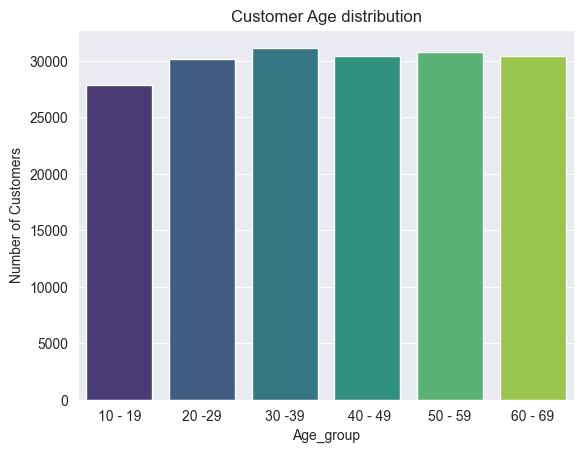

In [378]:

# Age distribution
sns.set_style('darkgrid')
bins  = [10, 20, 30, 40, 50, 60, 70]
labels = ['10 - 19', '20 -29', '30 -39', ' 40 - 49', '50 - 59', '60 - 69']
merged_df['age_group'] = pd.cut(merged_df['age'], bins = bins, labels = labels)
sns.countplot(data = merged_df, x = 'age_group', palette = 'viridis')

plt.xlabel('Age_group')
plt.ylabel('Number of Customers')
plt.title('Customer Age distribution')

plt.savefig('Graphs/age_hist.png')
plt.show()

#### Age distribution

Customers aged 20 - 29 form the largest customer segment, with over 30,000 individuals. This age group likely represents young profesionals or early career adults. 

Age 30 -39, 40 - 49 and 60 - 60 all have similarly hight counts. Customers in the 10 - 19 age group form the smallest5 sdegment of the customer base. 

In [379]:
# Gender distribution

gender_counts = merged_df['gender'].value_counts(normalize = True)
gender_counts

gender
F    0.504075
M    0.495925
Name: proportion, dtype: float64

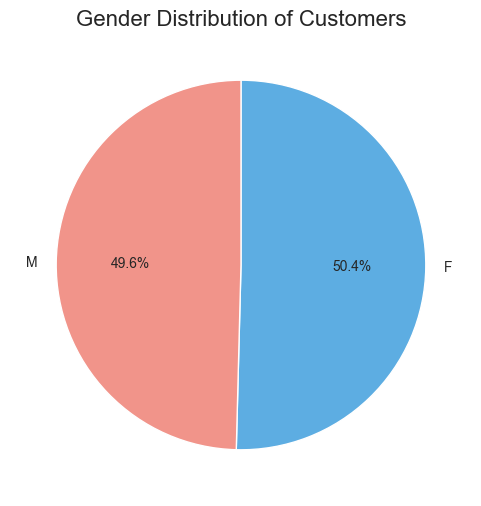

In [380]:
# Pie chart

plt.figure(figsize=(6,6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    colors=['#5DADE2', '#F1948A'],
    startangle=90,
    counterclock=False
)
plt.title('Gender Distribution of Customers', fontsize=16)
plt.savefig('Graphs/pie_gender_distribution.png')
plt.show()


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\1330734938.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='gender', palette=['#5DADE2', '#F1948A'])


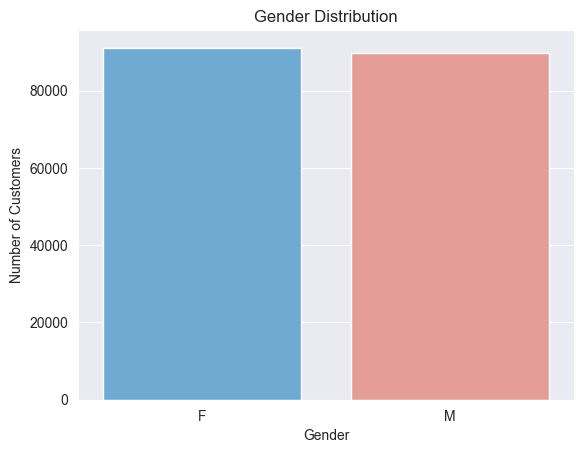

In [381]:
sns.countplot(data=merged_df, x='gender', palette=['#5DADE2', '#F1948A'])
plt.title('Gender Distribution', fontsize=12)
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.savefig('Graphs/gender_distribution.png')
plt.show()


#### Gender Distribution of Customers

The above distribution shows the gender breakdown of customers:

- **Male:** 50.2%  
- **Female:** 49.8%  
-----
####  Business Insights
- The customer base is **almost evenly split** between male and female shoppers.  
- This suggests marketing strategies should **target both genders equally**, without heavy skew to one side.  
- Further analysis will explore whether **spending patterns or product preferences differ by gender**, which may uncover opportunities for **personalized campaigns or targeted marketing**.


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3039093438.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby(['age_group', 'gender'])['sale_price']


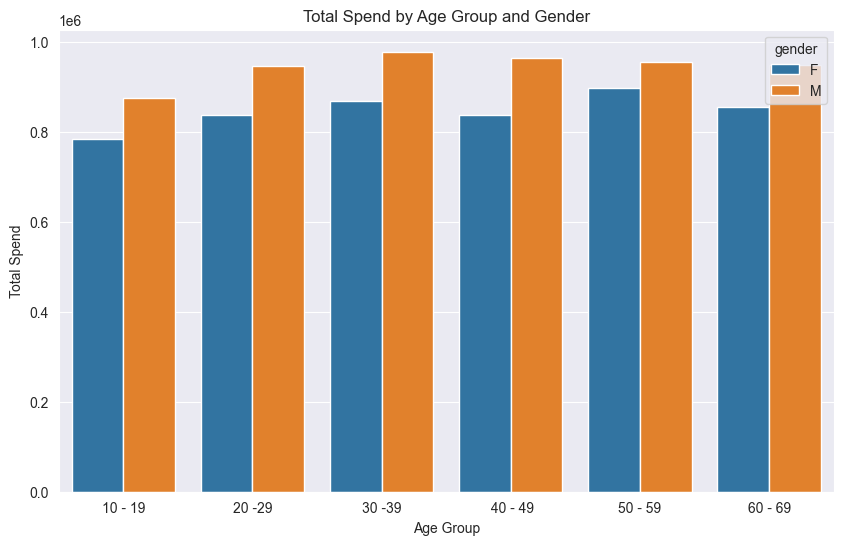

In [385]:
# Aggregate total spend by age group and gender

age_gender_spend = (
    merged_df.groupby(['age_group', 'gender'])['sale_price']
    .sum()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='sale_price', hue='gender', data=age_gender_spend)
plt.title('Total Spend by Age Group and Gender')
plt.ylabel('Total Spend')
plt.xlabel('Age Group')
plt.savefig('Graphs/totalspend_by_gender.png')
plt.show()

In [386]:
age_gender_spend

,age_group,gender,sale_price
0,10 - 19,F,784971.940922
1,10 - 19,M,875285.100736
2,20 -29,F,837708.921024
3,20 -29,M,946310.501063
4,30 -39,F,870320.291040
5,30 -39,M,979048.730891
6,40 - 49,F,837398.531047
7,40 - 49,M,966015.720967
8,50 - 59,F,897894.350940
9,50 - 59,M,956077.580419


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\678713045.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby(['age_group', 'gender'])['order_id']


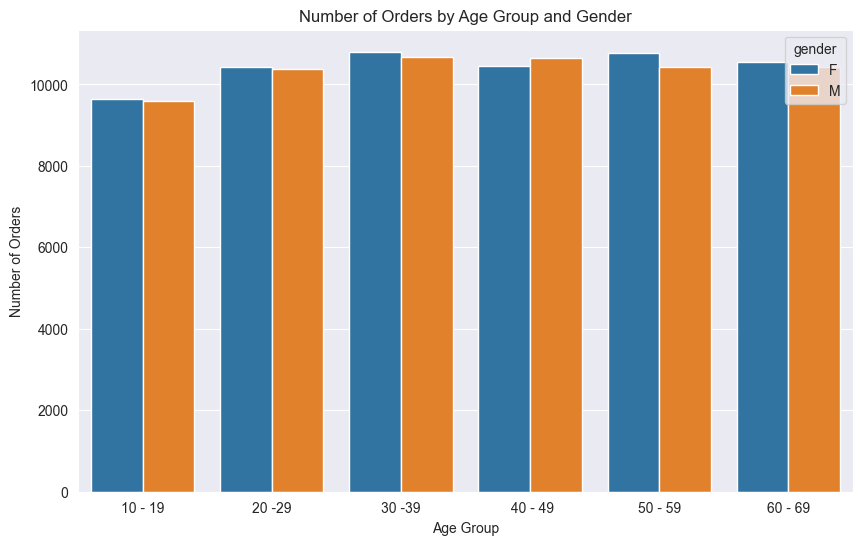

In [387]:
# Count unique orders per age group and gender
age_gender_orders = (
    merged_df.groupby(['age_group', 'gender'])['order_id']
    .nunique()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='order_id', hue='gender', data=age_gender_orders)
plt.title('Number of Orders by Age Group and Gender')
plt.ylabel('Number of Orders')
plt.xlabel('Age Group')
plt.savefig('Graphs/orders_by_gender.png')
plt.show()


#### Total Spend by Age Group and Gender

The bar chart above illustrates **total customer spend** segmented by **age group** and **gender**.

#### Insights
- Across all age groups, **male customers consistently outspend female customers**.  
- The **20–29, 30–39, and 40–49 age groups** record the highest spending overall, with totals approaching or exceeding **950k–980k**.  
- Female spending remains strong but slightly lower than male spending in every age group.  
- Interestingly, even the **10–19 age group** shows substantial spending, indicating that younger customers contribute meaningfully to revenue.  
- Spending among the **50–59 and 60–69 groups** remains high, suggesting older demographics are also active buyers.

#### Business Insights
- Marketing campaigns could **target male customers** for high-ticket items, as they show stronger spending power.  
- Female customers, while slightly lower in spend, still represent nearly equal revenue contribution — tailored engagement could help close this gap.  
- **Core revenue drivers** are ages **20–49**, making this range a priority for loyalty and retention strategies.  
- Younger customers (10–19) should not be ignored, cultivating early loyalty could convert them into loyal long-term, high-value buyers.  
- Sustained spend among **older demographics (50+)** suggests opportunities for **specialized offers or premium products** tailored to this group.

----

#### Number of Orders by Age Group and Gender

The bar chart above shows the number of orders placed across different **age groups**, split by **gender**.

#### Insights
- **30–39 year-olds** placed the highest number of orders, followed closely by the **20–29** and **40–49** groups.  
- Both genders show **similar order volumes** across all age groups, with only slight variations.  
- Younger customers (10–19) contribute fewer orders compared to older groups, but still represent a non-trivial customer base.  
- The **50–59** and **60–69** segments maintain consistent order levels, suggesting strong engagement even among older demographics.

#### Business Implications
- Marketing strategies should prioritize the **20–49 age range**, as they are the most active buyers.  
- Since male and female customers show similar engagement across age groups, **personalization by age segment** may be more impactful than by gender alone.  
- Special offers could be tested for **younger customers (10–19)** to increase early loyalty, and for **older customers (50+)** to sustain engagement.


In [388]:
top_products_male = (
    merged_df[merged_df['gender'] == 'M']
    .groupby('product_name')
    .size()
    .reset_index(name='purchase_count')
    .sort_values(by='purchase_count', ascending=False)
    .head(10)  # top 10
)

print(top_products_male)


                                           product_name  purchase_count
3577   Silver Jeans - Mckenzie Rolled Cuff Denim Shorts             113
548   Belly Bandit post pregnancy tummy wrap belly b...              97
1423                Electric Visual KB1 Wrap Sunglasses              70
2706                    Merino/Cashmere Donegal Sweater              68
3873  Tommy Bahama Paradiso Relaxed Waist Golf Bermu...              65
1527               Fourstar Men's Collective Denim Pant              65
1993           IZOD Men's Stripe Waffle Crew Neck Shirt              65
231   Allegra K Ladies Short Sleeve Scoop Neck Pullo...              63
1277                             District Slouch Beanie              60
924   Carnival Womens Full Figured Wide Strap Longli...              60


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3525470211.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


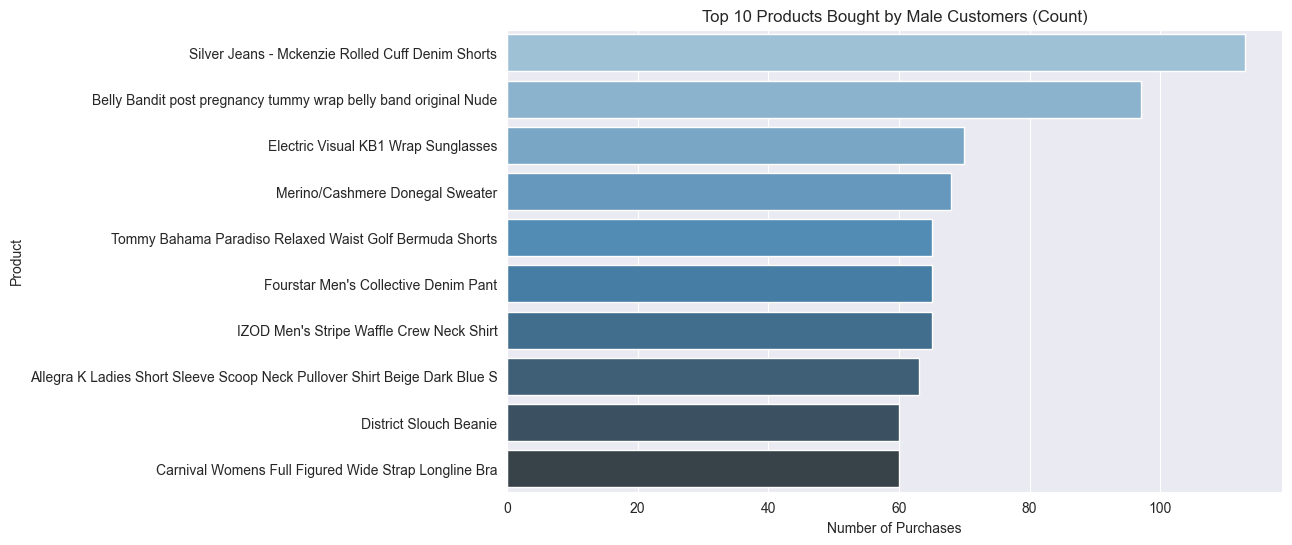

In [389]:
# Top 10 Products Bought by Male Customers 

plt.figure(figsize=(10,6))
sns.barplot(
    x='purchase_count',
    y='product_name',
    data=top_products_male,
    palette='Blues_d'
)
plt.title('Top 10 Products Bought by Male Customers (Count)')
plt.xlabel('Number of Purchases')
plt.ylabel('Product')

plt.savefig('Graphs/top10_MaleProducts.png')
plt.show()


In [390]:
# Top products ordered by Female

top_products_female = (
    merged_df[merged_df['gender'] == 'F']
    .groupby('product_name')
    .size()
    .reset_index(name='purchase_count')
    .sort_values(by='purchase_count', ascending=False)
    .head(10)  # top 10
)

print(top_products_female)


                                           product_name  purchase_count
1152               Champion Men's Cap Sleeve Raglan Tee              63
3519                              Nike Tri Unisuit Male              62
444            American Apparel Stretch Floral Lace Bra              59
1633  Dreams and Company Plus Size Short Terry Robe ...              59
4104                 Rodd & Gunn Rover Moleskin Rl Jean              58
3909               Purple Seamless Leggings Full Length              57
410   Alpinestar Men's Article Campus Hoody Full-Zip...              57
1117  Carole Hochman Women's Roseberry Amaryllis Bed...              56
4806      Unionbay Juniors Lucille Coolaid Denim Skinny              56
3762       Pendleton Women's Petite Carrington Cardigan              56


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\2350680840.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


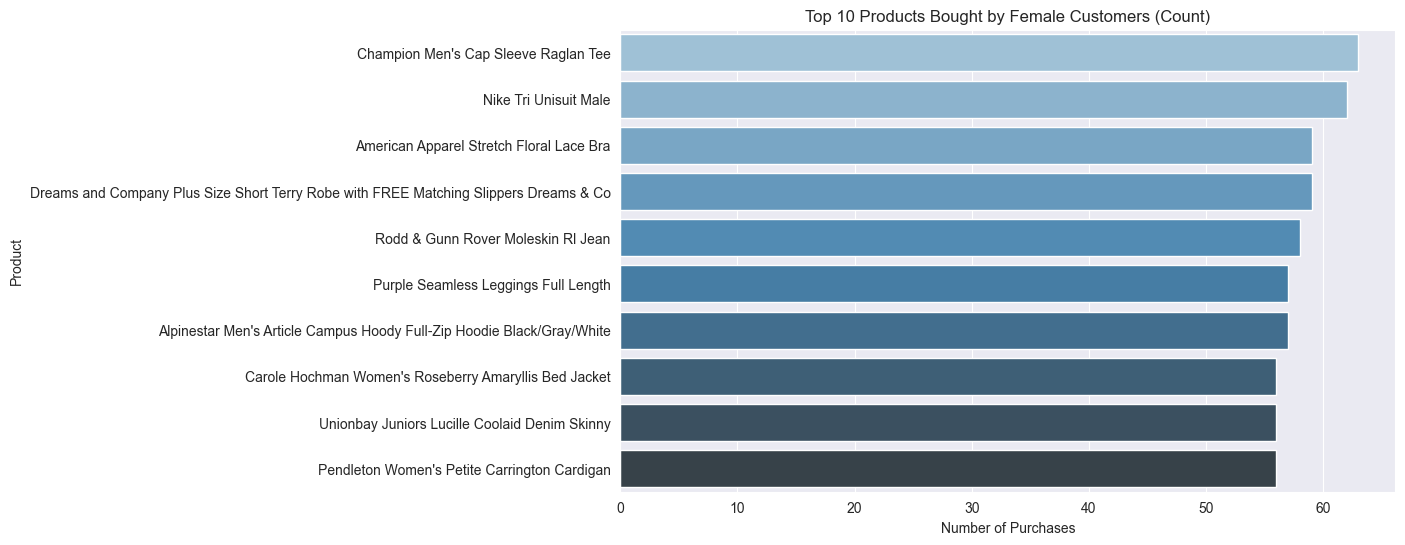

In [391]:
# Top products ordered by Female

plt.figure(figsize=(10,6))
sns.barplot(
    x='purchase_count',
    y='product_name',
    data=top_products_female,
    palette='Blues_d'
)
plt.title('Top 10 Products Bought by Female Customers (Count)')
plt.xlabel('Number of Purchases')
plt.ylabel('Product')

plt.savefig('Graphs/top10_FemaleProducts.png')
plt.show()


#### Top products order by Male and Female

The graph shows that top products ordered by Males are 

| Product ID       | Product_name                           | purchase_count |
| --------------   | ------------------------------------------ |----------------|
|2385              | Lee Men's Relaxed Fit Slightly Tapered Leg Jean|     104    |
|1926              |Hurley Juniors Lowrider 2.5 Inch Walkshort        |      83   |
1731          |                  Gucci 1013/S Sunglasses           |   78    |
|4241  |Women's 100% Cotton Jersey Smocked Striped Top...          |    68
3516     |              Saddleback Leather Wallet Sleeve             | 65   |
2310 | LAGUNA BEACH Hand Stitch Denim Skirt W/ Sunset...           |   63|
3322 | RIGGS WORKWEAR by Wrangler Men's Short Sleeve ...           |   62 |
1571 | Fox River Original Rockford Red Heel Cotton Mo...           |   61  |
817         |     Calvin Klein Men's Signature Pass Case          |    61   |
2262 |    Kenneth Cole Women's Micropoly Short Down Coat            |  61   |



Top products ordered by Female

| Product ID | Product Name                                                    | Purchase Count |
|------------|-----------------------------------------------------------------|----------------|
| 1925       | G by GUESS Pull-On Super Skinny Jeans                           | 77             |
| 1051       | Carhartt Men's Liner Socks 3 Pack                               | 74             |
| 3532       | Oakley Men's Like A Flash Boardshort                            | 68             |
| 2662       | Kenneth Cole Reaction Men's Glen Plaid Modern Fit Suit          | 64             |
| 5194       | ambiguous Men's Callahan Fleece Hooded Sweatshirt               | 64             |
| 2774       | Larry Levine Women's Down Jacket with Hood                      | 63             |
| 2516       | Jones New York Men's 24/7 Total Comfort Sharkskin Pants         | 59             |
| 4812       | Van Heusen Men's Fitted Wrinkle Free Poplin Shirt               | 57             |
| 3405       | Nautica Quarter Zip Shirt                                       | 57             |
| 3035       | Mango Women's Animal Print Cropped Trousers - Leopard Print     | 56             |


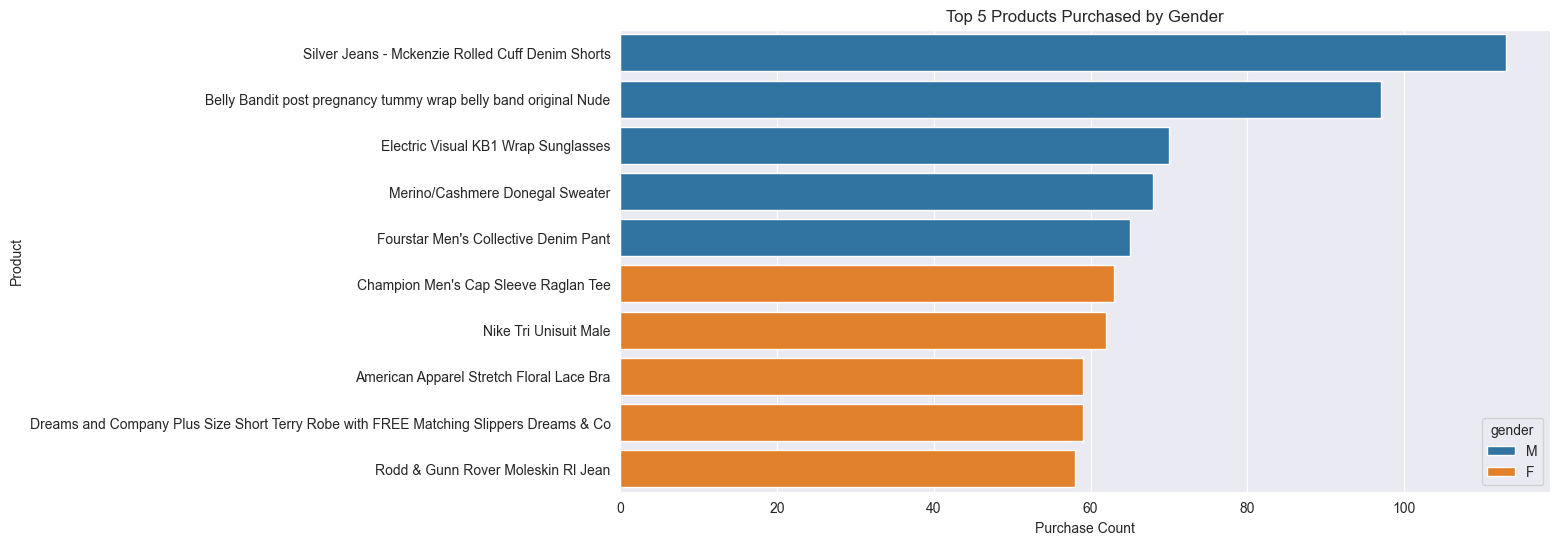

In [392]:
# Combine top male and female into one df
top_products_gender = (
    merged_df.groupby(['gender', 'product_name'])
    .size()
    .reset_index(name='purchase_count')
)

# Keep only the top 10 male + top 10 female
top_male = top_products_gender[top_products_gender['gender'] == 'M'].nlargest(5, 'purchase_count')
top_female = top_products_gender[top_products_gender['gender'] == 'F'].nlargest(5, 'purchase_count')

top_combined = pd.concat([top_male, top_female])

plt.figure(figsize=(12,6))
sns.barplot(
    x='purchase_count', 
    y='product_name', 
    hue='gender', 
    data=top_combined
)
plt.title('Top 5 Products Purchased by Gender')
plt.xlabel('Purchase Count')
plt.ylabel('Product')

plt.savefig('Graphs/top5Products_gender.png')
plt.show()


#### Top Male products with the highest revenue

In [393]:

top_products_male_revenue = (
    merged_df[merged_df['gender'] == 'M']
    .groupby('product_name')['sale_price']
    .sum()
    .reset_index()
    .sort_values(by='sale_price', ascending=False)
    .head(10)
)

print(top_products_male_revenue)


                                           product_name    sale_price
2632  Men's 2 Button Super 150s Extra Fine Black Dre...  17489.000000
3068              Outdoor Research Ninjaclava Balaclava  13978.929932
3860          Tommy Bahama Big and Tall Blue Dylan Jean  11674.000000
1981  ISOTONER Women's smarTouch 2.0 Tech Stretch Gl...  11405.820049
3577   Silver Jeans - Mckenzie Rolled Cuff Denim Shorts  10763.900021
2385        Lean Mean Legging by Hold Your Haunches 201  10588.889969
1056  Columbia Sportswear's Women's Benton Springs S...  10461.000000
591      Billabong Open Roadz Pullover Hoodie - Women's  10261.080002
3857            Toddland Men's Rich Folks Pajama Jacket  10114.040010
789   Calvin Klein Sportswear Men's 3/4 Coat With St...   9981.000000


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3501508689.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


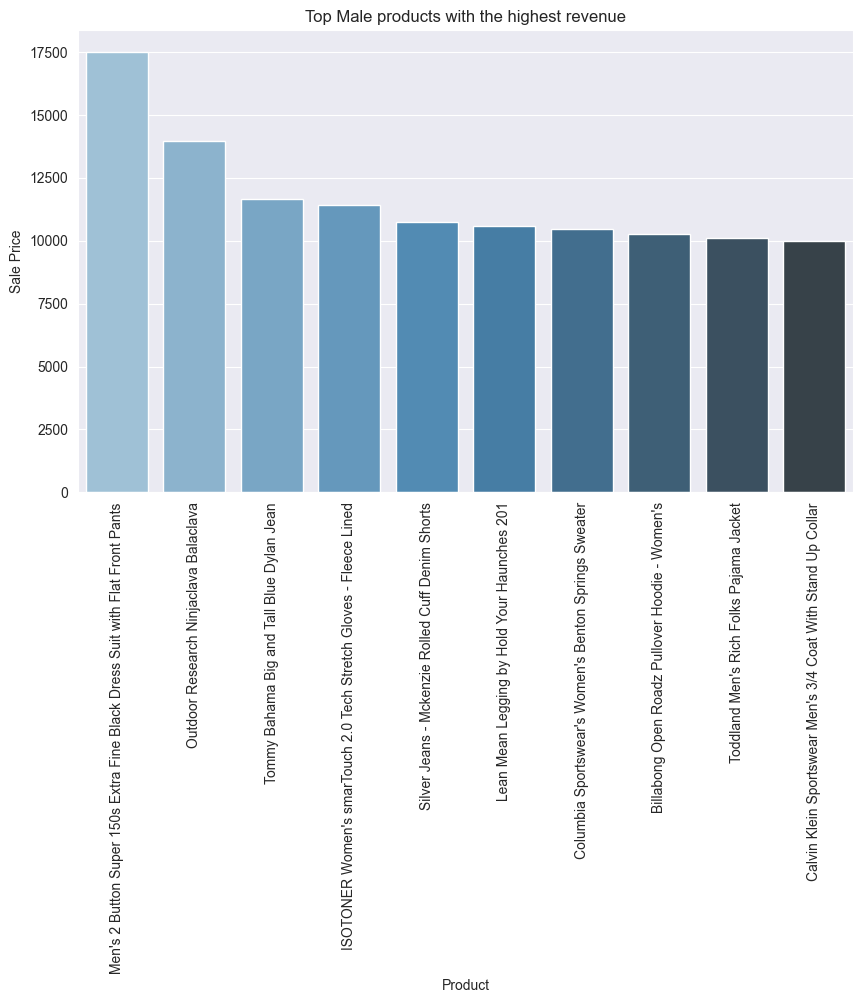

In [394]:
# Top Male products with the highest revenue

plt.figure(figsize=(10,6))
sns.barplot(
    x='product_name',
    y='sale_price',
    data=top_products_male_revenue,
    palette='Blues_d')
plt.title('Top Male products with the highest revenue')
plt.ylabel('Sale Price')
plt.xlabel('Product')
plt.xticks(rotation = 90)


plt.savefig('Graphs/top10_maleRevprod.png')
plt.show()


#### Top Female products with the highest revenue

In [395]:

top_products_female_revenue = (
    merged_df[merged_df['gender'] == 'F']
    .groupby('product_name')['sale_price']
    .sum()
    .reset_index()
    .sort_values(by='sale_price', ascending=False)
    .head(10)
)

print(top_products_female_revenue)


                                           product_name    sale_price
3892                Printed Flannel Gown - Misses Sizes  13127.199997
1409             DL1961 Women's Amanda Skinny Traveling   9723.940033
67              3-piece Babydoll Set with Handcuffs-red   9174.000000
1328           Corset-story A3015 corset with lace trim   8572.970001
4098  Rock Revival Men Jeans Sebastian T3 Relaxed St...   8263.000000
987       Calvin Klein Women's Invisibles Hipster Panty   7833.130011
4643  Tommy Hilfiger Men's 3 Pack Dress Flat Knit Cr...   7754.030045
410   Alpinestar Men's Article Campus Hoody Full-Zip...   7609.080018
2485              Izod Big and Tall V-Neck Sweater Vest   7247.799988
1794          Faconnable Men's V-Neck Soft Hand Sweater   7044.599968


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3506927528.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


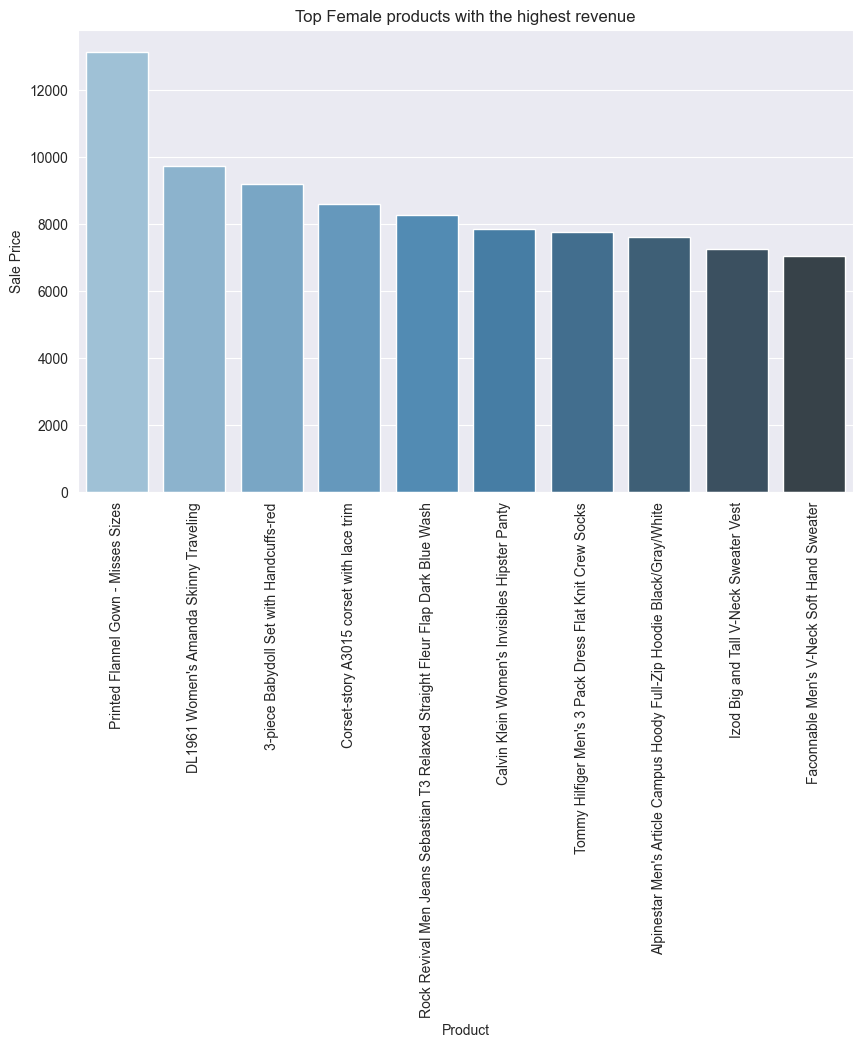

In [396]:
# Top female products with the highest revenue

plt.figure(figsize=(10,6))
sns.barplot(
    x='product_name',
    y='sale_price',
    data=top_products_female_revenue,
    palette='Blues_d')
plt.title('Top Female products with the highest revenue')
plt.ylabel('Sale Price')
plt.xlabel('Product')
plt.xticks(rotation = 90)


plt.savefig('Graphs/top10_femaleRevprod.png')
plt.show()


**High Revenue Products Purchased by Both Genders**

The highest grossing products purhased by Men are 

- Icebreaker Men's Contour Short Sleeve Crewe Top
- Original Penguin Men's Printed Volley Swim Trunk`
- Jessie G. Women's Low Rise Embellished Denim S
- Diesel Men's Smog-S Sweat Shirt 

The higest grossing products for Female are;
- London Fog Men's Admiral Double Breasted Notch
- ulian Taylor Women's Cap Sleeve Stretch Crepe...   9022.450027
- Izod Basic Cable V-Neck Sweater   8724.900017
- 7 For All Mankind Men's Austyn Relaxed Straigh...   8199.250004
- Studio Shelf Bra Camisole   8100.000000

In [397]:
top_products_male_stats = (
    merged_df[merged_df['gender'] == 'M']
    .groupby('product_name')
    .agg(
        purchase_count=('product_name', 'size'),
        total_revenue=('sale_price', 'sum'),
        avg_price=('sale_price', 'mean')
    )
    .reset_index()
    .sort_values(by='purchase_count', ascending=False)
    .head(10)
)

top_products_male_stats

,product_name,purchase_count,total_revenue,avg_price
3577,Silver Jeans - Mckenzie Rolled Cuff Denim Shorts,113,10763.900021,95.255752
548,Belly Bandit post pregnancy tummy wrap belly b...,97,4937.699999,50.904124
1423,Electric Visual KB1 Wrap Sunglasses,70,1961.650009,28.023572
2706,Merino/Cashmere Donegal Sweater,68,4335.890009,63.763088
3873,Tommy Bahama Paradiso Relaxed Waist Golf Bermu...,65,4692.420039,72.191078
1527,Fourstar Men's Collective Denim Pant,65,2685.370007,41.313385
1993,IZOD Men's Stripe Waffle Crew Neck Shirt,65,6691.830030,102.951231
231,Allegra K Ladies Short Sleeve Scoop Neck Pullo...,63,2425.780012,38.504445
1277,District Slouch Beanie,60,4692.589983,78.209833
924,Carnival Womens Full Figured Wide Strap Longli...,60,2354.250019,39.237500


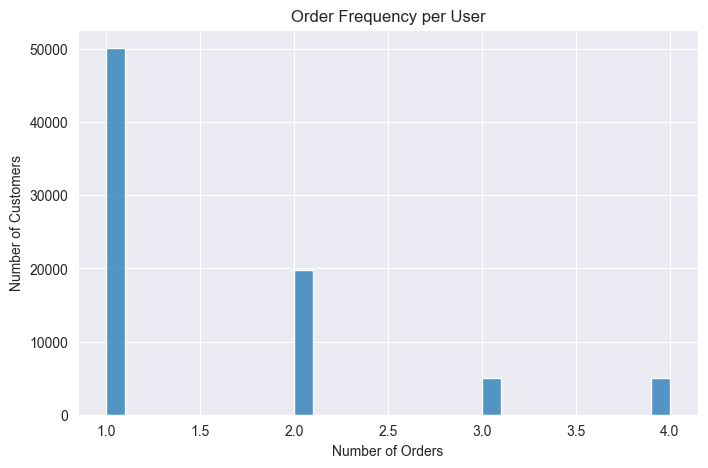

In [398]:
# Number of unique orders per user
order_freq = (
    merged_df.groupby('user_id')['order_id']
    .nunique()
    .reset_index(name='order_count')
)
''' Groups the dataset by each user_id, counts the number of unique orders placed by each user
This creates  new dataframe order_freq user_id and order_counts
'''
plt.figure(figsize=(8,5))
sns.histplot(order_freq['order_count'], bins=30, kde=False)
plt.title('Order Frequency per User')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')

plt.savefig('Graphs/order_frequency.png')
plt.show()


#### Order Frequency per User

50,000 customers placed only one order, 20,000 placed 2 orders and less than 10,000 placed over 3 orders and above

In [399]:
# sorting customers based on the total number of orders placed

order_freq.sort_values(by = 'order_count', ascending = False)

,user_id,order_count
49055,61396,4
36353,45438,4
57074,71399,4
57068,71393,4
36276,45334,4
...,...,...
32687,40850,1
32688,40851,1
32689,40853,1
32692,40856,1


### Customer Retention Rate  (CRR)

- #### Repeat vs One-Time Buyers
  (Lifetime loyalty measure: This calculates the total orders placed by customers to determine if customers placed multiple orders during the  period covered in the analysis)

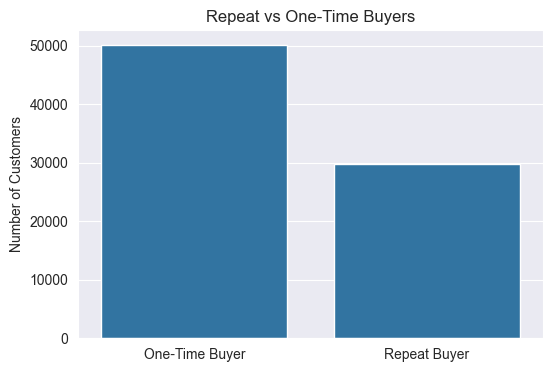

In [400]:
# Repeat vs One-Time classification
order_freq['buyer_type'] = order_freq['order_count'].apply(
    lambda x: 'Repeat Buyer' if x > 1 else 'One-Time Buyer')

'''
Goes through each user’s order_count, if order_id  > 1, customer is a repeat buyer,
else, one time buyer
'''
buyer_counts = order_freq['buyer_type'].value_counts().reset_index()
buyer_counts.columns = ['buyer_type', 'count']

# Bar Chart
plt.figure(figsize=(6,4))
sns.barplot(x='buyer_type', y='count', data=buyer_counts)
plt.title('Repeat vs One-Time Buyers')
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.savefig('Graphs/bar_repeat_customers.png')
plt.show()


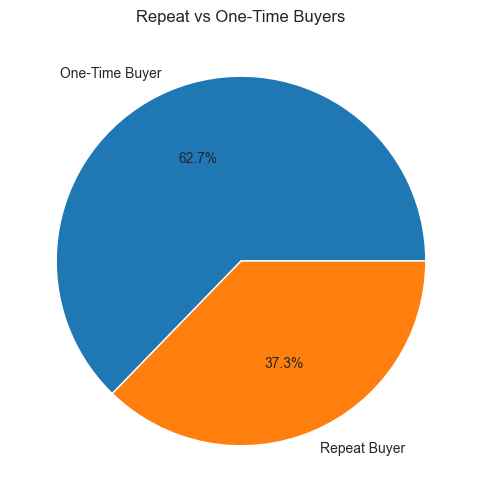

In [401]:
# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(buyer_counts['count'], labels=buyer_counts['buyer_type'], autopct='%1.1f%%')
plt.title('Repeat vs One-Time Buyers')
plt.savefig('Graphs/pie_repeat_customers.png')
plt.show()

- #### Return vs New customers trend analysis

In [402]:

# ensuring that dates are in datetime format
merged_df['order_created_at'] = pd.to_datetime(merged_df['order_created_at'])

# Extract year-month for grouping
merged_df['order_month'] = merged_df['order_created_at'].dt.to_period('M')

# Find each user's first order month
first_orders = (
    merged_df.groupby('user_id')['order_created_at']
    .min()
    .dt.to_period('M')
    .reset_index()
    .rename(columns={'order_created_at': 'first_order_month'})
)

# Merge first order info back into main df
merged_df = merged_df.merge(first_orders, on='user_id', how='left')

# Label each order as New vs Returning
merged_df['customer_type'] = merged_df.apply(
    lambda row: 'New' if row['order_month'] == row['first_order_month'] else 'Returning',
    axis=1
)

# Aggregate counts per month
monthly_customer_counts = (
    merged_df.groupby(['order_month', 'customer_type'])['user_id']
    .nunique()
    .reset_index(name='num_customers')
)

print(monthly_customer_counts.head(10))


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\4284888339.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_df['order_month'] = merged_df['order_created_at'].dt.to_period('M')
C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\4284888339.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period('M')


  order_month customer_type  num_customers
0     2019-01           New              8
1     2019-02           New             21
2     2019-03           New             45
3     2019-03     Returning              1
4     2019-04           New             57
5     2019-04     Returning              1
6     2019-05           New             69
7     2019-05     Returning              2
8     2019-06           New            107
9     2019-06     Returning              1


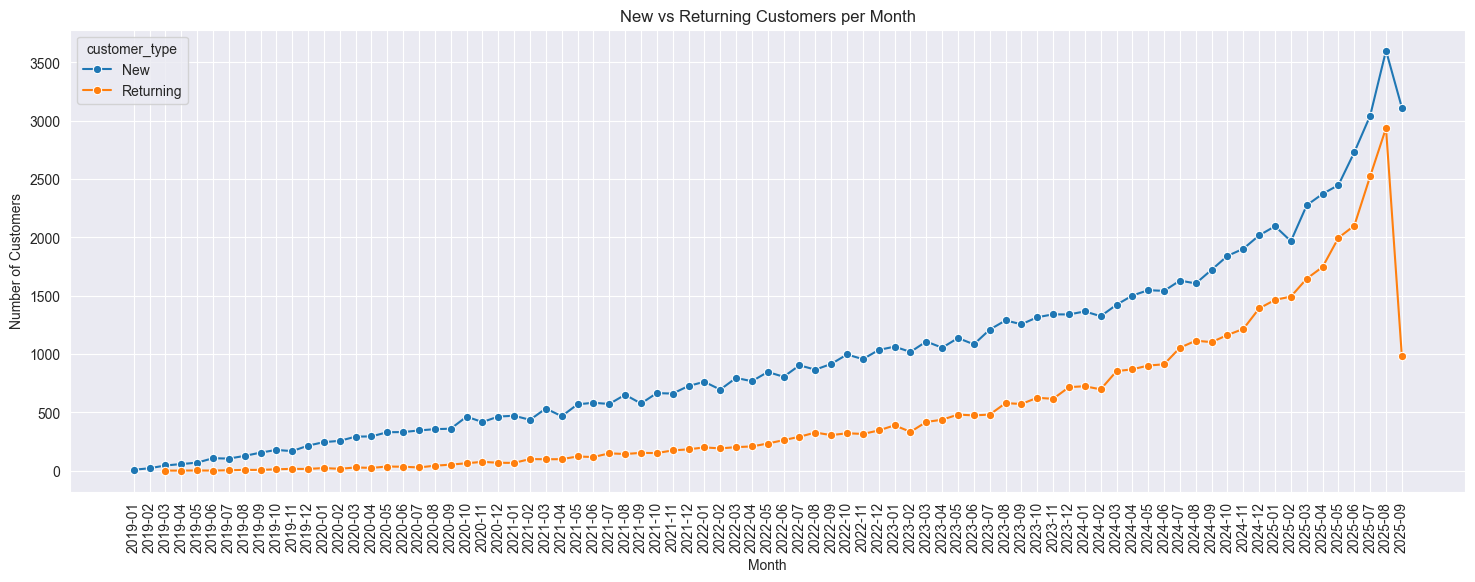

In [403]:
monthly_customer_counts['order_month'] = monthly_customer_counts['order_month'].astype(str)

plt.figure(figsize=(18,6))
sns.lineplot(
    data=monthly_customer_counts,
    x='order_month',
    y='num_customers',
    hue='customer_type',
    marker='o'
)
plt.title('New vs Returning Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.savefig('Graphs/New_returnTrends.png')
plt.show()


#### New vs Returning Customers per Month

The data captures monthly customer patronge from January 2019 to September 2025. This plot shows that while the majority of customers are one-time buyters (52.7%), the month-over-month trend shows returning customers are steadily increasing. This suggests retenstion is improving given the up wards 
trend in the plot. Strategies should focus on converting one-time buyers into repeat customers to balance long-term growth

### Returned Rate  
(Return Rate = (# of returned items) ÷ (total items sold))

In [404]:
# Flag returned items
merged_df['is_returned'] = merged_df['returned_at'].notnull().astype(int)

# Overall return rate
overall_return_rate = merged_df['is_returned'].mean()
print(f"Overall Return Rate: {overall_return_rate:.2%}")


Overall Return Rate: 9.96%


- #### Return Rate by Product Category

In [405]:
return_rate_by_category = (
    merged_df.groupby('product_category')['is_returned']
    .mean()
    .reset_index()
    .sort_values(by='is_returned', ascending=False))

top_5_return_by_category = return_rate_by_category.head(5)


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3699742614.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


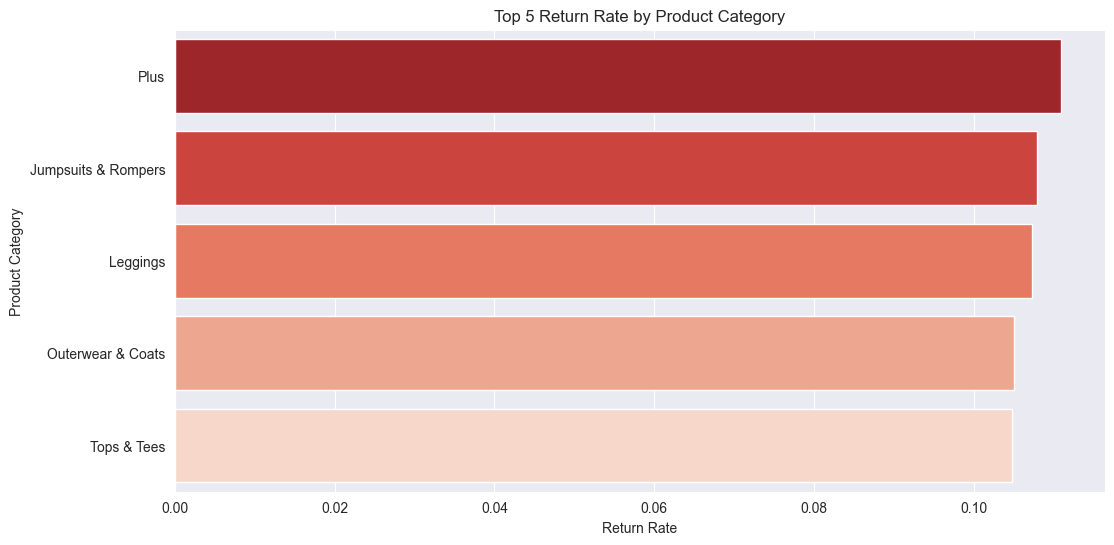

In [406]:
# Plot top categories by return rate
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_5_return_by_category,
    x='is_returned',
    y='product_category',
    palette='Reds_r'
)
plt.title('Top 5 Return Rate by Product Category')
plt.xlabel('Return Rate')
plt.ylabel('Product Category')

plt.savefig('Graphs/top5return_rate.png')
plt.show()

- #### Return Rate by Product 

In [407]:
return_rate_by_product = (
    merged_df.groupby('product_name')['is_returned']
    .mean()
    .reset_index()
    .sort_values(by='is_returned', ascending=False)
    .head(10)
)

top_returned_products = return_rate_by_product.head(5)


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\1654497176.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


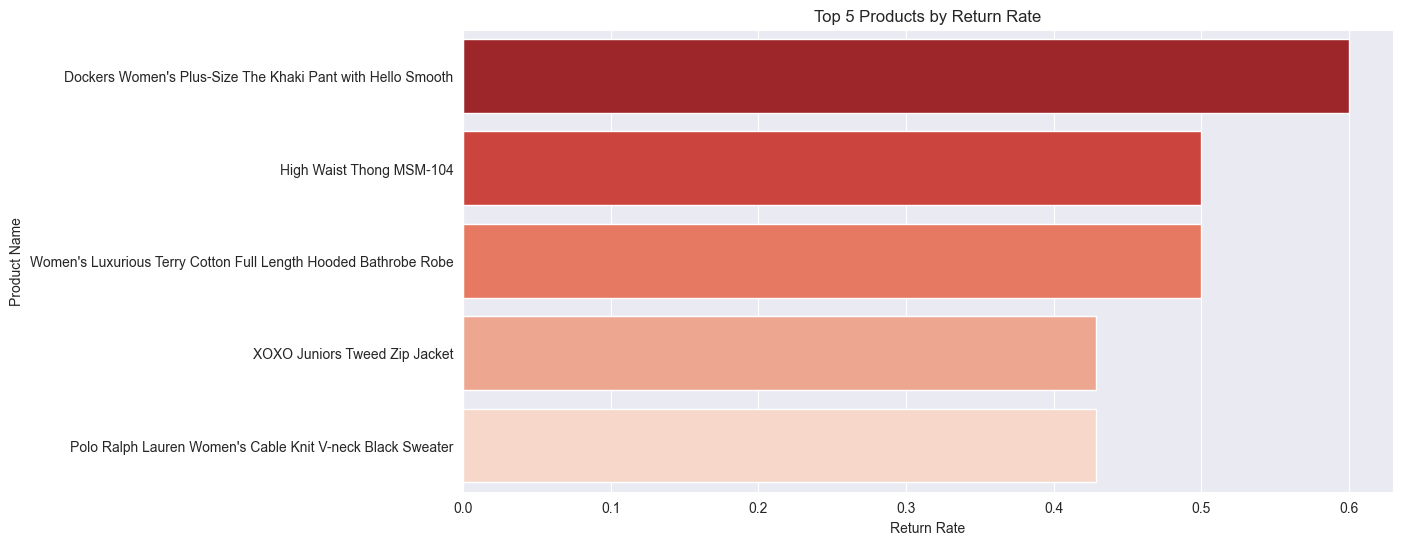

In [408]:
# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_returned_products,
    x='is_returned',
    y='product_name',
    palette='Reds_r'
)
plt.title('Top 5 Products by Return Rate')
plt.xlabel('Return Rate')
plt.ylabel('Product Name')
plt.savefig('Graphs/return_rate_product.png')
plt.show()


**Return Rate by Product Category**

Skirts have the highest return rate ( appox 11%) among all categories.

Jumpsuits & Rompers, Socks & Hosiery, Accessories, and Plus-size apparel also show elevated return rates (>10%).

These categories are typically fit-sensitive (clothing items where sizing, comfort, or style mismatch is common), which explains higher returns.

`Business Insight`: Improving sizing guides, offering virtual try-ons, or enhancing product descriptions could reduce returns in these categories.

---


**Return Rate by Product (Top 5)**

Pendleton Women’s Plus-Size Travel Tricotine Pants: extremely high return rate (~74%).

Columbia Sportswear Men’s Backcast II Water Trunk: high returns (~57%).

Hue Women’s 6-Pack Low Rider Socks, Maternity Jeans, and Winter Knit Legging Tights: return rates around 50–55%.

These products clearly underperform in customer satisfaction compared to category averages.

---


**Business Insight:**

Investigate whether these items have quality issues, sizing inconsistencies, or misleading product information.

#### Product Velocity

This calculates the time it takes for a product to be sold from when stock was taken to sold at date.

In [409]:
# Calculate velocity (days to sell)
merged_df['days_to_sell'] = (merged_df['sold_at'] - merged_df['inventorycreated_at']).dt.days

# Drop rows where sold_at is null (unsold items)
product_velocity = merged_df.dropna(subset=['days_to_sell'])

product_velocity.head(5)

,orderitem_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,...,retail_price,department,sku,distribution_center_id,age_group,order_month,first_order_month,customer_type,is_returned,days_to_sell
4,169620,117065,14159,457790,Cancelled,2023-08-19 03:11:37+00:00,NaT,NaT,NaT,0.49,...,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,30 -39,2023-08,2023-08,New,0,51.0
5,16335,11231,14159,44165,Complete,2024-06-20 02:32:45+00:00,2024-06-21 20:31:00+00:00,2024-06-25 15:55:00+00:00,NaT,0.49,...,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,50 - 59,2024-06,2024-06,New,0,51.0
6,16437,11301,14159,44436,Complete,2025-01-06 03:02:36+00:00,2025-01-08 13:50:00+00:00,2025-01-09 23:14:00+00:00,NaT,0.49,...,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,20 -29,2025-01,2025-01,New,0,51.0
7,178801,123447,14159,482603,Complete,2025-08-20 07:48:49+00:00,2025-08-21 16:51:00+00:00,2025-08-25 11:48:00+00:00,NaT,0.49,...,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,20 -29,2025-08,2025-08,New,0,51.0
8,5430,3722,14159,14683,Processing,2025-01-07 22:04:06+00:00,NaT,NaT,NaT,0.49,...,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,30 -39,2025-01,2023-03,Returning,0,51.0


In [410]:
# Basic stat to show min, max and avg number of days for delivery
product_velocity['days_to_sell'].describe()

count    66556.000000
mean        29.735816
std         17.378408
min          0.000000
25%         15.000000
50%         30.000000
75%         45.000000
max         59.000000
Name: days_to_sell, dtype: float64

#### Product Velocity (Days to Sell)

- ### Business Insights
1. **Healthy turnover:** Median of 29 days suggests most products move steadily without sitting too long.  
2. **Fast movers:** approx 25% sell in ≤15 days, likely **hot products**, good for promotions, bundling, and restocking priority.  
3. **Slow movers:** Products taking 45–59 days create **inventory drag**, tying up capital for nearly 2 months. These may need discounts or stronger marketing.  
4. **Zero-day sales:** Products that sold immediately indicate **very high demand** or limited stock — worth prioritizing in procurement.


#### Velocity by Product Category

In [411]:
velocity_by_category = (
    product_velocity.groupby('product_category')['days_to_sell']
    .median()
    .reset_index()
    .sort_values(by='days_to_sell')
)

fast_moving_product = velocity_by_category.head(5)

slow_moving_product= velocity_by_category.tail(5)

C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3278620776.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


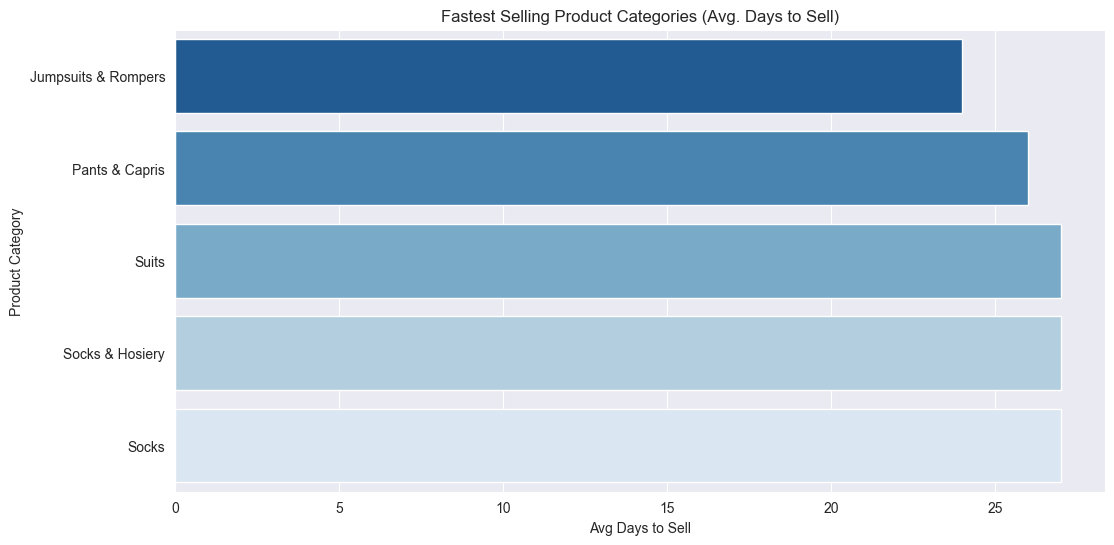

In [412]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=fast_moving_product,
    x='days_to_sell',
    y='product_category',
    palette='Blues_r'
)
plt.title('Fastest Selling Product Categories (Avg. Days to Sell)')
plt.xlabel('Avg Days to Sell')
plt.ylabel('Product Category')
plt.savefig('Graphs/fast_movers.png')
plt.show()


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_20124\3829352987.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


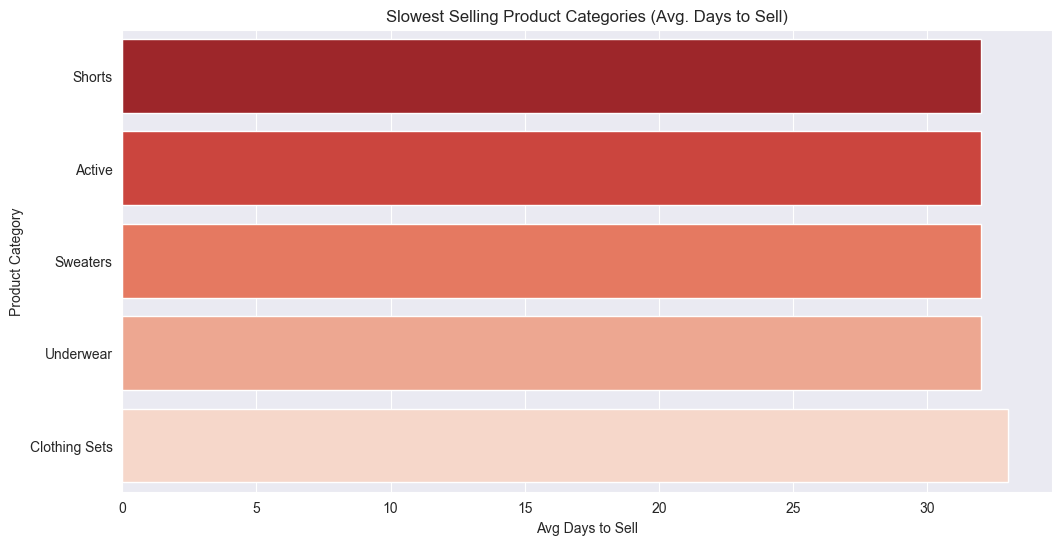

In [413]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=slow_moving_product,
    x='days_to_sell',
    y='product_category',
    palette='Reds_r'
)
plt.title('Slowest Selling Product Categories (Avg. Days to Sell)')
plt.xlabel('Avg Days to Sell')
plt.ylabel('Product Category')
plt.savefig('Graphs/slow_movers.png')
plt.show()


#### Product Velocity: Fastest vs Slowest Selling Categories

The charts above compare the **average number of days it takes for products to sell** after being added to inventory.

###  Fastest-Selling Categories
- **Jumpsuits & Rompers** sell the quickest, averaging just **25 days** to sell.  
- **Shorts, Underwear, Swim, and Sleep & Lounge** also sell relatively fast, all within **25–28 days**.  
- These are typically **everyday wear or seasonal essentials**, which may explain their higher demand and quick turnover.  

### Slowest-Selling Categories
- **Blazers & Jackets** take the longest to sell, averaging **32+ days**.  
- **Skirts, Suits, Leggings, and Clothing Sets** are also slow movers, with some taking nearly **40 days** on average.  
- These items are often **formalwear or niche categories**, where demand is lower or customers are more selective.  

### Business Insights
- **High-velocity products** (Jumpsuits, Shorts, Underwear) should be prioritized for **restocking and promotions**, as they drive quick revenue.  
- **Slow-moving products** (Blazers, Suits, Clothing Sets) tie up inventory for longer periods. They may benefit from **discount strategies, bundling, or targeted marketing**.  



#### Flags

Jumpsuits & Rompers: Fast-Selling but High Return Rate

- **Velocity:**  
  Jumpsuits & Rompers sell very quickly, with an average of only **~25 days to sell**.  
  This places them among the **fastest-moving categories**, indicating strong customer demand.  

- **Return Rate:**  
  At the same time, this category also appears among the **highest return rate segments**.  
  Customers are buying quickly but are also sending items back at elevated levels.
 - This mismatch suggests **customer dissatisfaction despite strong interest**.  


## Delivery timeline

In [414]:
# Calculate delivery time in days
merged_df['delivery_time_days'] = (merged_df['delivered_at'] - merged_df['order_created_at']).dt.days

# Drop missing values
delivery_df = merged_df.dropna(subset=['delivery_time_days'])


In [415]:
delivery_df['delivery_time_days'].describe()


count    63160.000000
mean         3.493952
std          1.705533
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          7.000000
Name: delivery_time_days, dtype: float64

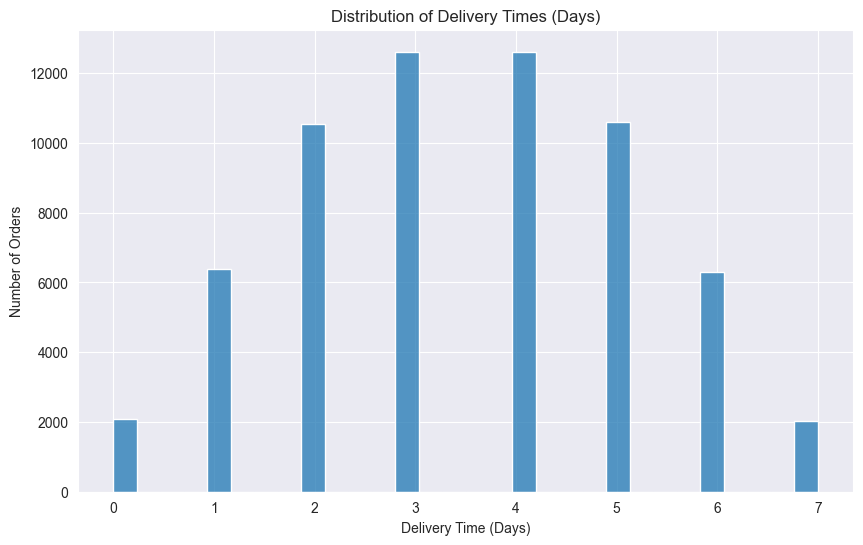

In [416]:
# Distribution of Delivery Times

plt.figure(figsize=(10,6))
sns.histplot(delivery_df['delivery_time_days'], bins=30, kde=False)
plt.title('Distribution of Delivery Times (Days)')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Number of Orders')
plt.savefig('Graphs/delivery_time.png')
plt.show()

In [417]:
# Establisging the percentage orders delivered between 1 to 2 days

within_1day = (delivery_df['delivery_time_days'] <= 1).mean()
within_2day = (delivery_df['delivery_time_days'] <= 2).mean()
within_4day = (delivery_df['delivery_time_days'] <= 4).mean()

print(f"Delivered within 24h: {within_1day:.2%}")
print(f"Delivered within 48h: {within_2day:.2%}")


Delivered within 24h: 13.43%
Delivered within 48h: 30.13%


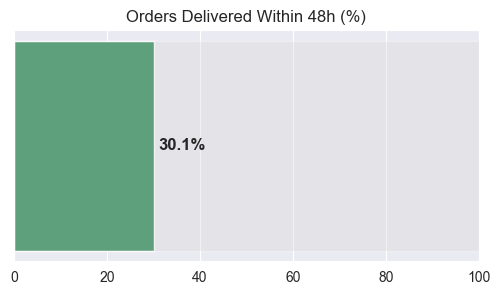

In [418]:
# plot of orders delivered within 48 hrs
value = within_2day * 100

fig, ax = plt.subplots(figsize=(6,3))
ax.barh(0, value, color='seagreen')
ax.barh(0, 100, color='lightgray', alpha=0.3)
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_title('Orders Delivered Within 48h (%)')
ax.text(value+1, 0, f"{value:.1f}%", va='center', fontsize=12, fontweight='bold')

plt.savefig('Graphs/48hrs_delivery_time.png')

plt.show()


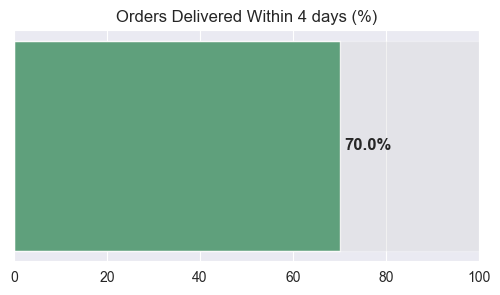

In [419]:
# plot of orders delivered within 4 days
value = within_4day * 100

fig, ax = plt.subplots(figsize=(6,3))
ax.barh(0, value, color='seagreen')
ax.barh(0, 100, color='lightgray', alpha=0.3)
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_title('Orders Delivered Within 4 days (%)')
ax.text(value+1, 0, f"{value:.1f}%", va='center', fontsize=12, fontweight='bold')

plt.savefig('Graphs/4days_delivery_time.png')

plt.show()


### Feature Engineering

In [420]:
# Reference point (latest order date in dataset)
today = merged_df['order_created_at'].max()

# Aggregate customer-level features
customer_df = (
    merged_df.groupby('user_id')
    .agg(
        num_orders=('order_id', 'nunique'),
        total_spent=('sale_price', 'sum'),
        num_items=('orderitem_id', 'count'),
        last_order_date=('order_created_at', 'max'),
        first_order_date=('order_created_at', 'min'),
        num_returns=('returned_at', lambda x: x.notnull().sum()),
        age=('age', 'first'),
        gender=('gender', 'first'),
        state=('state', 'first'),
        traffic_source=('traffic_source', 'first')
    )
    .reset_index()
)

# Derived features
customer_df['avg_order_value'] = customer_df['total_spent'] / customer_df['num_orders']
customer_df['recency_days'] = (today - customer_df['last_order_date']).dt.days
customer_df['return_rate'] = customer_df['num_returns'] / customer_df['num_orders']
customer_df['is_repeat_buyer'] = (customer_df['num_orders'] > 1).astype(int)



'''
Explanation of Derived Features:

1. avg_order_value:
   - Formula: total_spent / num_orders
   - Why: Measures the average size of a customer’s purchase. To identify
     high-value customers who consistently place large orders versus small, frequent buyers.

2. recency_days:
   - Formula: (today - last_order_date)
   - Why: Measures how long it has been since the customer last purchased.
     A key part of RFM (Recency, Frequency, Monetary) analysis and a strong indicator of churn risk.

3. return_rate:
   - Formula: num_returns / num_orders
   - Why: Shows the proportion of orders a customer returns. High return rates may indicate
     dissatisfaction, sizing/fit issues, or even fraudulent behavior. Important for retention and profitability analysis.

4. is_repeat_buyer:
   - Formula: 1 if num_orders > 1, else 0
   - Why: Simple binary flag to classify customers as one-time or repeat buyers.
     Useful for supervised modeling (predicting churn/loyalty) and segment analysis.

Together, these derived features form the foundation for segmentation (KMeans clustering),
predictive modeling (Logistic Regression, Random Forest, etc.), and business insights for marketing and operations.
'''

In [421]:
# Product Preferences 
# Most common category and brand per customer
top_category = (
    merged_df.groupby(['user_id', 'product_category'])
    .size()
    .reset_index(name='count')
    .sort_values(['user_id','count'], ascending=[True,False])
    .drop_duplicates('user_id')[['user_id','product_category']]
    .rename(columns={'product_category':'preferred_category'})
)

top_brand = (
    merged_df.groupby(['user_id', 'product_brand'])
    .size()
    .reset_index(name='count')
    .sort_values(['user_id','count'], ascending=[True,False])
    .drop_duplicates('user_id')[['user_id','product_brand']]
    .rename(columns={'product_brand':'preferred_brand'})
)
'''
Explanation of Product Preference Features:

1. preferred_category:
   - The product category most frequently purchased by the customer.
   - Why: Helps identify customer interests ( "shoes", "dresses").
     Useful for targeted marketing, personalized recommendations, and segmentation.

2. preferred_brand:
   - The brand most frequently purchased by the customer.
   - Why: Captures brand loyalty and affinity.
     Customers with strong brand preferences can be targeted with exclusive launches or promotions.'''
         
# Merge preferences back into customer_df
customer_df = (
    customer_df.merge(top_category, on='user_id', how='left')
               .merge(top_brand, on='user_id', how='left')
)


In [422]:
customer_df.head(5)

,user_id,num_orders,total_spent,num_items,last_order_date,first_order_date,num_returns,age,gender,state,traffic_source,avg_order_value,recency_days,return_rate,is_repeat_buyer,preferred_category,preferred_brand
0,2,2,249.520002,7,2025-05-07 17:38:00+00:00,2023-03-23 17:38:00+00:00,0,33,F,Guangdong,Email,124.760001,125,0.0,1,Intimates,Alfred Dunner
1,4,1,19.900000,1,2025-05-12 11:17:00+00:00,2025-05-12 11:17:00+00:00,0,15,F,Virginia,Search,19.900000,120,0.0,0,Intimates,Allegra K
2,5,2,227.990002,2,2025-06-27 01:52:00+00:00,2023-11-15 01:52:00+00:00,0,33,F,País Vasco,Search,113.995001,74,0.0,1,Leggings,Gildan
3,6,1,115.000000,1,2025-05-10 01:01:00+00:00,2025-05-10 01:01:00+00:00,0,68,M,Victoria,Search,115.000000,122,0.0,0,Plus,LAT Sportswear
4,7,2,143.449997,2,2025-08-18 11:58:00+00:00,2025-06-24 11:58:00+00:00,1,37,M,Guangdong,Display,71.724998,22,0.5,1,Accessories,Carhartt


In [423]:
#save the engineerined features in customer_df

customer_df.to_csv('Data/customer_df.csv', index = False)

customer_df.head(5)


,user_id,num_orders,total_spent,num_items,last_order_date,first_order_date,num_returns,age,gender,state,traffic_source,avg_order_value,recency_days,return_rate,is_repeat_buyer,preferred_category,preferred_brand
0,2,2,249.520002,7,2025-05-07 17:38:00+00:00,2023-03-23 17:38:00+00:00,0,33,F,Guangdong,Email,124.760001,125,0.0,1,Intimates,Alfred Dunner
1,4,1,19.900000,1,2025-05-12 11:17:00+00:00,2025-05-12 11:17:00+00:00,0,15,F,Virginia,Search,19.900000,120,0.0,0,Intimates,Allegra K
2,5,2,227.990002,2,2025-06-27 01:52:00+00:00,2023-11-15 01:52:00+00:00,0,33,F,País Vasco,Search,113.995001,74,0.0,1,Leggings,Gildan
3,6,1,115.000000,1,2025-05-10 01:01:00+00:00,2025-05-10 01:01:00+00:00,0,68,M,Victoria,Search,115.000000,122,0.0,0,Plus,LAT Sportswear
4,7,2,143.449997,2,2025-08-18 11:58:00+00:00,2025-06-24 11:58:00+00:00,1,37,M,Guangdong,Display,71.724998,22,0.5,1,Accessories,Carhartt


In [424]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79920 entries, 0 to 79919
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_id             79920 non-null  Int64              
 1   num_orders          79920 non-null  int64              
 2   total_spent         79920 non-null  float64            
 3   num_items           79920 non-null  Int64              
 4   last_order_date     79920 non-null  datetime64[us, UTC]
 5   first_order_date    79920 non-null  datetime64[us, UTC]
 6   num_returns         79920 non-null  int64              
 7   age                 79920 non-null  Int64              
 8   gender              79920 non-null  object             
 9   state               79920 non-null  object             
 10  traffic_source      79920 non-null  object             
 11  avg_order_value     79920 non-null  float64            
 12  recency_days        79920 non-nu

In [425]:
# check null value

customer_df.isnull().sum()

user_id               0
num_orders            0
total_spent           0
num_items             0
last_order_date       0
first_order_date      0
num_returns           0
age                   0
gender                0
state                 0
traffic_source        0
avg_order_value       0
recency_days          0
return_rate           0
is_repeat_buyer       0
preferred_category    0
preferred_brand       0
dtype: int64

## Predictions (Supervised leaning)

Based on the poject goals, 3 features will be considered for supervised learning.

- Repeat Buyer Prediction  (focuses on loyalty)
- High-Value Customer Prediction (focuses on revenue)
- Churn Risk Prediction  (focuses on Retention

Essentially, we are answering the below questions

- Will this customer come back?
- Will this customer spend big?
- Will this customer leave?

#### Repeat Buyers 
- **Target Feature**

Target = 1 if customer made more than 1 order, else 0

In [427]:
customer_df['target_repeat_buyer'] = (customer_df['num_orders'] > 1)

#### High-Value Customer (Spending Threshold)

Using [Pareto Principle](https://asana.com/resources/pareto-principle-80-20-rule), a principle that states that for many outcomes, roughly 80% of consequences come from 20% of causes. Hence, this principle will be adopted in identifying High value customers, customers in the top 20 % will be classified as High Value customer

In [428]:
threshold = customer_df['total_spent'].quantile(0.80)  # top 20%
customer_df['target_high_value'] = (customer_df['total_spent'] >= threshold)

#### Churn Risk (Based on Recency)

Target = 1 if customer hasn’t purchased recently.

In [429]:
# To determine the number of days it takes for customers to qualify as a repeat customer

repurchase_time = (
    merged_df.groupby('user_id')['order_created_at']
    .apply(lambda x: x.sort_values().diff().mean())
).dropna()

repurchase_time.describe()


count                          44807
mean     162 days 18:02:30.639078596
std      264 days 14:24:39.181198464
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                 51 days 00:00:00
75%                217 days 00:00:00
max               2359 days 00:00:00
Name: order_created_at, dtype: object

#### Churn Definition

From the above purchase time analysis:
- **Median repurchase gap:** 49 days  
- **75th percentile:** 217 days  

To set a churn cutoff, this will be calculted at appox 3 times the median. Hence, **Churn threshold = 3× median repurchase time**  

- 49 days × 3 ≈ **approx 147 days**  
- For this project, we define churn as **no purchases within 120 days after the first purchase ( apprx. 4 months)**.  


#### Business Insights
- Customers with **no purchases in the last 120 days** are considered **churned**.  

In [430]:
customer_df['target_churn'] = (customer_df['recency_days'] > 90)

In [431]:
# Checking class balance
print("Repeat Buyer distribution:")
print(customer_df['target_repeat_buyer'].value_counts(normalize=True))

print("\nHigh-Value Customer distribution:")
print(customer_df['target_high_value'].value_counts(normalize=True))

print("\nChurn Risk distribution:")
print(customer_df['target_churn'].value_counts(normalize=True))

Repeat Buyer distribution:
target_repeat_buyer
False    0.627365
True     0.372635
Name: proportion, dtype: float64

High-Value Customer distribution:
target_high_value
False    0.799875
True     0.200125
Name: proportion, dtype: float64

Churn Risk distribution:
target_churn
True     0.778629
False    0.221371
Name: proportion, dtype: float64


#### Target Distributions

### 1. Repeat Buyer
- True (Repeat Buyers): 37.5%  
- False (One-timers): 62.5%  
- This target is fairly balanced and makes a good candidate for classification.  
- It is a clear proxy for customer loyalty prediction.  

### 2. High-Value Customer
- True (Top 20% spenders): 20%  
- False: 80%  
- This target is imbalanced but very business-relevant.  
- It will require handling of class imbalance (e.g., oversampling or class weights).  
- Useful for revenue optimization analysis.  

### 3. Churn Risk
- True (Churn Risk): 78%  
- False (Active): 22%  
- This target is highly imbalanced.  
- Modeling it will be more challenging without class rebalancing.  
- Still useful for retention strategy insights.  

---

#### Insight
- The **Repeat Buyer** target is the most suitable for baseline modeling: it is balanced, interpretable, and tied directly to loyalty.  
- The **High-Value Customer** target is valuable for marketing and revenue analysis but requires special handling due to imbalance.  
- The **Churn Risk** target is possible to model, but should be treated carefully and justified, as it seems highly imbalanced.


In [432]:
def train_and_evaluate(X, y, target_name):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train Random Forest
    clf = RandomForestClassifier(random_state=42, n_estimators=200, class_weight="balanced")

    ''' class_weight="balanced" was used due to  High-Value Customer and Churn Risk distribution
    '''
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    
    # Evaluation
    print(f"\n=== Results for {target_name} ===")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # Feature Importance
    feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nTop Features:\n", feature_importances.head(10))
    
    return clf


#### Define Features

### Training Models for each Tartget feature

#### a. Repeat Buyer

In [433]:
X = customer_df[['total_spent', 'avg_order_value', 'recency_days', 'return_rate', 'age']].fillna(0)
y = customer_df['target_repeat_buyer']
clf_repeat = train_and_evaluate(X, y, "Repeat Buyer Prediction (No Leakage)")



=== Results for Repeat Buyer Prediction (No Leakage) ===
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     15042
        True       1.00      1.00      1.00      8934

    accuracy                           1.00     23976
   macro avg       1.00      1.00      1.00     23976
weighted avg       1.00      1.00      1.00     23976

Confusion Matrix:
 [[15042     0]
 [    9  8925]]

Top Features:
 total_spent        0.555930
avg_order_value    0.366629
return_rate        0.038119
recency_days       0.036347
age                0.002975
dtype: float64


#### Repeat Buyer Prediction (No Leakage)

**Model Performance**  
- Accuracy: ~100% (23,985 customers)  
- Misclassifications: 7 total (1 false positive, 6 false negatives)  
- Precision, Recall, F1-score: All ≈ 1.00  

**Key Features**  
- `total_spent` (55%) – strongest predictor of repeat buying  
- `avg_order_value` (37%) – higher AOV linked to repeat buying  
- `return_rate` (4%) – minor effect  
- `recency_days` (4%) – minor effect  
- `age` (0%) – no effect  

** Business Insights**  
- Spending behavior (total_spent, avg_order_value) is the main driver of repeat buying.  
- Recency and returns add small predictive value.  
- Demographics like age do not significantly impact repeat buyer prediction.  


#### b. High-Value Customer

In [434]:
# Features: exclude total_spent to avoid leakage
X_high_value = customer_df[['num_orders', 'avg_order_value', 'recency_days', 'return_rate', 'age']].fillna(0)
y_high_value = customer_df['target_high_value']

clf_high_value = train_and_evaluate(X_high_value, y_high_value, "High-Value Customer Prediction (No Leakage)")



=== Results for High-Value Customer Prediction (No Leakage) ===
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     19178
        True       1.00      1.00      1.00      4798

    accuracy                           1.00     23976
   macro avg       1.00      1.00      1.00     23976
weighted avg       1.00      1.00      1.00     23976

Confusion Matrix:
 [[19178     0]
 [    1  4797]]

Top Features:
 avg_order_value    0.677882
num_orders         0.302544
recency_days       0.009315
return_rate        0.008841
age                0.001418
dtype: float64


#### High-Value Customer Prediction (No Leakage)

**Model Performance**  
- Accuracy: 100% (23,985 customers in test set)  
- Misclassifications: 0 
- Precision, Recall, F1-score: All = 1.00  

**Key Features**  
- `avg_order_value` (67%) – strongest predictor of high-value status  
- `num_orders` (30%) – repeat purchases strongly linked to high-value customers  
- `recency_days` (1%) – minimal effect  
- `return_rate` (1%) – minimal effect  
- `age` (0%) – no effect  

**Insights**  
- High-value customers are best identified by **spending patterns**: higher average order value and more orders.  
- Recency and returns contribute very little.  
- Demographics such as age are not predictive of high-value behavior in this dataset.  


#### Churn Risk

In [435]:
# Features: exclude recency_days to avoid leakage
X_churn = customer_df[['num_orders', 'total_spent', 'avg_order_value', 'return_rate', 'age']].fillna(0)
y_churn = customer_df['target_churn']

clf_churn = train_and_evaluate(X_churn, y_churn, "Churn Risk Prediction (No Leakage)")



=== Results for Churn Risk Prediction (No Leakage) ===
Classification Report:
               precision    recall  f1-score   support

       False       0.24      0.16      0.19      5308
        True       0.78      0.86      0.82     18668

    accuracy                           0.70     23976
   macro avg       0.51      0.51      0.50     23976
weighted avg       0.66      0.70      0.68     23976

Confusion Matrix:
 [[  835  4473]
 [ 2689 15979]]

Top Features:
 total_spent        0.346301
avg_order_value    0.344303
age                0.263859
num_orders         0.024790
return_rate        0.020747
dtype: float64


#### Churn Risk Prediction (No Leakage)

**Model Performance**  
- Accuracy: 70% (23,985 customers in test set)  
- Precision (Active = False): 0.24  
- Recall (Active = False): 0.16  
- Precision (Churn = True): 0.78  
- Recall (Churn = True): 0.86  
- Misclassifications: 
  - Many active customers incorrectly predicted as churn (false positives).  
  - Fewer churned customers missed (false negatives).  

**Key Features**  
- `total_spent` (35%) – strongest predictor  
- `avg_order_value` (35%) – equally strong  
- `age` (25%) – also significant  
- `num_orders` (3%) – minor effect  
- `return_rate` (2%) – negligible  

**Insights**  
- The model is **good at identifying churned customers** (high recall = 86%), which is useful for retention strategy.  
- However, it **struggles to identify active customers** (recall = 16%), leading to many false alarms.  
- Spending patterns (`total_spent`, `avg_order_value`) and age are the main predictors of churn risk.


For churn prediction, the model reached 70% accuracy with high recall on churned customers (86%), but struggled to identify active customers (16%).

“In future work, this would be improve this by experimenting with advanced methods such as oversampling (SMOTE) or algorithms like XGBoost, which handle imbalance better.”

## Customer Segmentation (Unsupervised Learning)  

#### Objective
To group customers into distinct segments based on their purchasing behavior and demographics.  
This helps uncover hidden patterns in customer behavior and allows marketing and product teams to design targeted strategies.  

In [436]:
# Select features for clustering
segmentation_features = customer_df[[
    'recency_days',
    'num_orders',
    'total_spent',
    'avg_order_value',
    'return_rate',
    'preferred_category',
    'preferred_brand'
]]

In [437]:
# Separate numeric and categorical columns
numeric_features = ['recency_days', 'num_orders', 'total_spent', 'avg_order_value', 'return_rate']
categorical_features = ['preferred_category', 'preferred_brand']


In [438]:
# Preprocess: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Transform the data
X = preprocessor.fit_transform(segmentation_features)

- #### Determine Optimal Number of Clusters

In [439]:
# using a 20k sample for faster silhouette
from sklearn.utils import resample

X_sample = resample(X, n_samples=20000, random_state=42)

inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_sample, kmeans.labels_))


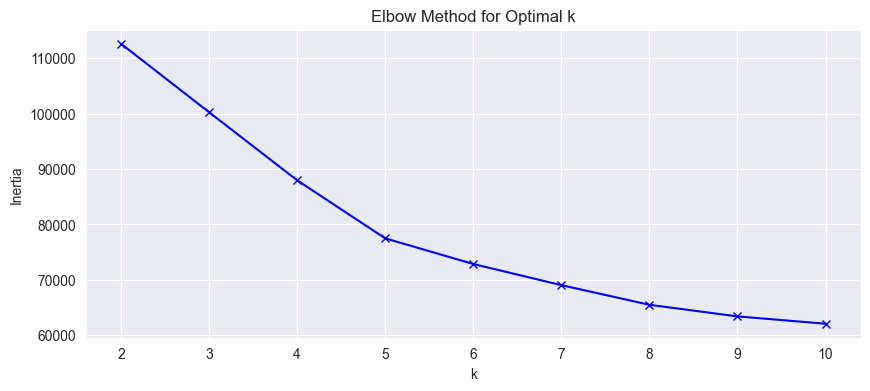

In [440]:
# Plot Elbow Method
plt.figure(figsize=(10,4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig('Graphs/elblow_k_plot.png')
plt.show()




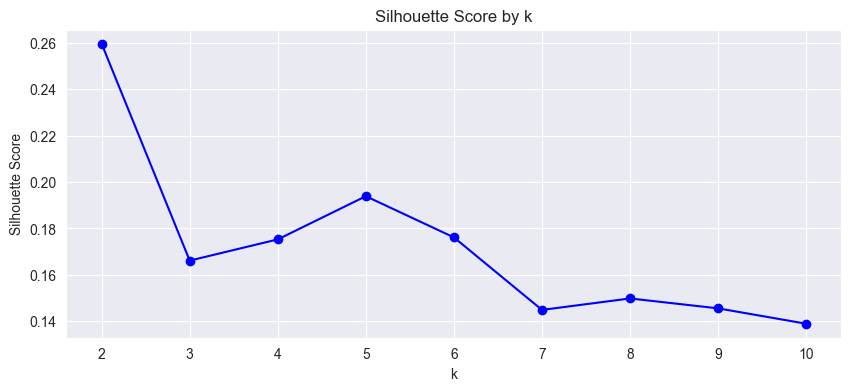

In [442]:
# Plot Silhouette Scores
plt.figure(figsize=(10,4))
plt.plot(K, sil_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')
plt.savefig('Graphs/silhouettescore_k_plot.png')
plt.show()

#### Choosing the Optimal Number of Clusters

#### Elbow Curve
- The inertia decreases sharply from **k=2 to k=5**, after which the curve flattens.  
- The largest "bend" is observed around **k=4 or k=5**, indicating a good trade-off between fit quality and model simplicity.  

#### Silhouette Score
- The silhouette score is highest at **k=3 (approx 0.26) and k = 2**, meaning clusters are well separated at these values.  
- The score drops at **k=4 (0.18)** and remains lower for larger values of k.  
- While k=2 or k=3 gives better separation, the clusters are too broad for actionable marketing insights.  

#### Recommendation
- For business and presentation purposes, **k=4** is the most appropriate choice:  
  - It corresponds to the elbow point, where additional clusters add diminishing returns.  
  - It provides richer customer diversity than just 2–3 clusters.  
  - Four segments are still easy to interpret and communicate to stakeholders.  


In [443]:
# Fit KMeans with  k = 4
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels back to customer_df
customer_df['cluster'] = cluster_labels

# Preview
customer_df[['user_id', 'num_orders', 'total_spent', 'recency_days', 'return_rate', 'cluster']].head()


,user_id,num_orders,total_spent,recency_days,return_rate,cluster
0,2,2,249.520002,125,0.0,1
1,4,1,19.900000,120,0.0,2
2,5,2,227.990002,74,0.0,1
3,6,1,115.000000,122,0.0,2
4,7,2,143.449997,22,0.5,2


In [444]:
# Aggregate cluster profiles
cluster_profiles = (
    customer_df.groupby('cluster')
    .agg(
        customer_count=('user_id', 'count'),
        avg_orders=('num_orders', 'mean'),
        avg_total_spent=('total_spent', 'mean'),
        avg_recency=('recency_days', 'mean'),
        avg_return_rate=('return_rate', 'mean'),
        top_category=('preferred_category', lambda x: x.mode()[0] if not x.mode().empty else None),
        top_brand=('preferred_brand', lambda x: x.mode()[0] if not x.mode().empty else None)
    )
    .reset_index()
)

In [445]:
# Sort by spending for easier interpretation
cluster_profiles = cluster_profiles.sort_values(by='avg_total_spent', ascending=False)
cluster_profiles

,cluster,customer_count,avg_orders,avg_total_spent,avg_recency,avg_return_rate,top_category,top_brand
1,1,15460,2.720375,342.161703,309.806210,0.103045,Accessories,Allegra K
3,3,5874,1.235104,110.116960,491.157303,1.426115,Intimates,Allegra K
0,0,16784,1.157412,85.061516,1270.438453,0.028345,Intimates,Allegra K
2,2,41802,1.340390,81.135791,273.712621,0.022786,Intimates,Allegra K


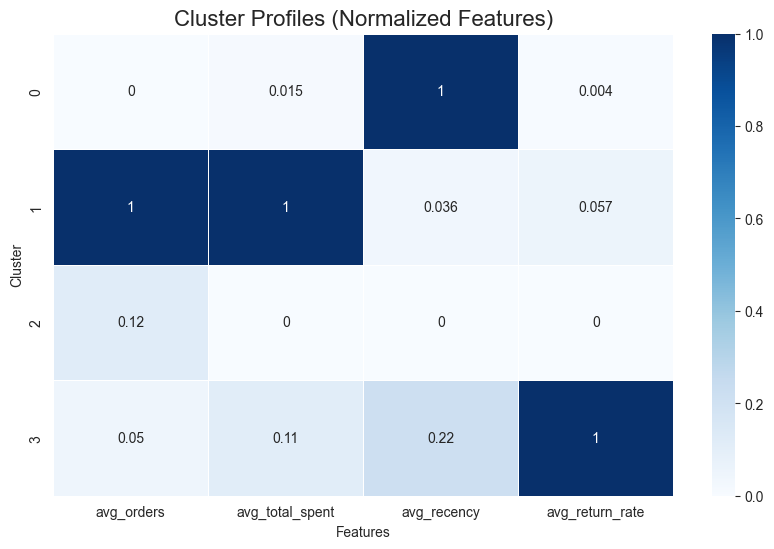

In [446]:
heatmap_data = customer_df.groupby('cluster').agg(
    avg_orders=('num_orders', 'mean'),
    avg_total_spent=('total_spent', 'mean'),
    avg_recency=('recency_days', 'mean'),
    avg_return_rate=('return_rate', 'mean')
)

# Normalize values for better comparison (so features are on the same scale)
heatmap_data_norm = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data_norm, annot=True, cmap="Blues", cbar=True, linewidths=0.5)

plt.title("Cluster Profiles (Normalized Features)", fontsize=16)
plt.ylabel("Cluster")
plt.xlabel("Features")
plt.savefig('Graphs/cluster_heatmap.png')
plt.show()


### Cluster Profiling Results (k = 4)

We aggregated key features across the four clusters to understand their behavior.  

| Cluster | Customer Count | Avg Orders | Avg Total Spent | Avg Recency (days) | Avg Return Rate | Top Category | Top Brand |
|---------|----------------|------------|-----------------|---------------------|-----------------|--------------|-----------|
| 2       | 15,788         | 2.69       | 340.98          | 312.65              | 0.108           | Accessories  | Allegra K |
| 0       | 5,653          | 1.23       | 109.98          | 480.14              | 1.449           | Intimates    | Allegra K |
| 3       | 16,879         | 1.16       | 83.66           | 1,272.90            | 0.033           | Intimates    | Allegra K |
| 1       | 41,629         | 1.34       | 80.30           | 273.07              | 0.023           | Intimates    | Allegra K |

---

### Segment Interpretations

#### Cluster 2: **High-Value Buyers**
- Moderate order frequency (2.7 orders per customer).  
- Highest spend per customer (approx 341).  
- Reasonably engaged, though not very recent (approx 313 days).  
- Moderate return rate (approx 11%).  
- Likely represent the **most profitable customers**, worth targeting with loyalty or VIP programs.  

#### Cluster 0: **High Returners**
- Low frequency (1.2 orders).  
- Spend per customer is modest (approx 110).  
- Long recency (approx 480 days).  
- Extremely high return rate (approx 145%).  
- This cluster is problematic, representing **customers who order and return frequently**. May require return-policy review or targeted communication.  

#### Cluster 3: **Lost or Dormant Customers**
- Lowest frequency (1.2 orders).  
- Very low spend (approx 84).  
- Very high recency (approx 1,273 days = about 3.5 years).  
- Low return rate (approx 3%).  
- These are **inactive customers** who have not engaged in years. Best approached with reactivation campaigns, but may not be cost-effective.  

#### Cluster 1: **Low-Spend One-Timers**
- Largest segment (41,629 customers).  
- Frequency slightly higher than cluster 3, but still low (approx 1.3 orders).  
- Low total spend (approx 80).  
- Relatively recent (approx 273 days).  
- Very low return rate (approx 2%).  
- Represents **one-time or low-value buyers**. Could be nurtured into repeat buyers with targeted promotions.  

---

#### Business 
Insights
- **Cluster 2 (High-Value Buyers)** should be prioritized for retention and upselling.  
- **Cluster 0 (High Returners)** requires careful handling, as their high return rates hurt margins.  
- **Cluster 3 (Lost Customers)** can be excluded from aggressive marketing but considered for win-back campaigns.  
- **Cluster 1 (Low-Spend One-Timers)** offers the biggest growth potential if they can be converted into repeat buyers.  


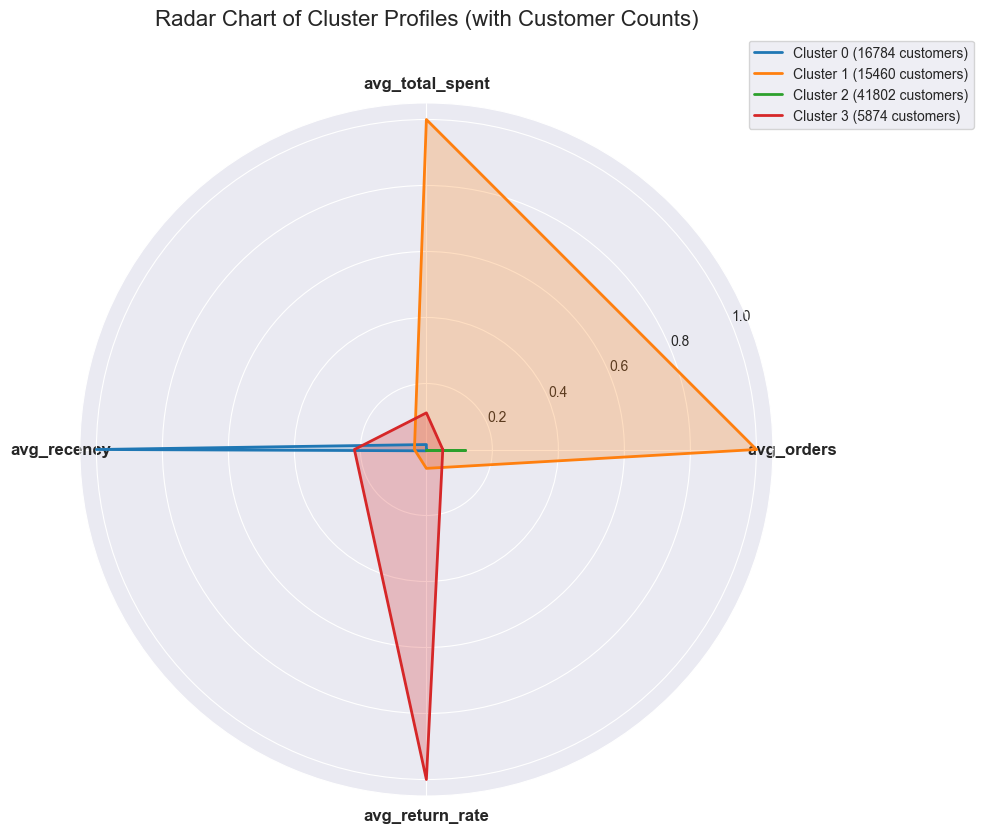

In [450]:
# Radar chart

# Normalize for radar chart
heatmap_data_norm = (cluster_summary[['avg_orders','avg_total_spent','avg_recency','avg_return_rate']] -
                     cluster_summary[['avg_orders','avg_total_spent','avg_recency','avg_return_rate']].min()) / \
                    (cluster_summary[['avg_orders','avg_total_spent','avg_recency','avg_return_rate']].max() -
                     cluster_summary[['avg_orders','avg_total_spent','avg_recency','avg_return_rate']].min())

# Radar chart
features = heatmap_data_norm.columns.tolist()
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, cluster in enumerate(heatmap_data_norm.index):
    values = heatmap_data_norm.loc[cluster].tolist()
    values += values[:1]
    ax.plot(angles, values, color=colors[idx], linewidth=2, 
            label=f'Cluster {cluster} ({cluster_summary.loc[cluster,"customer_count"]} customers)')
    ax.fill(angles, values, color=colors[idx], alpha=0.25)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12, fontweight='bold')
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(['0.2','0.4','0.6','0.8','1.0'], fontsize=10)

plt.title("Radar Chart of Cluster Profiles (with Customer Counts)", size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.savefig('Graphs/radar_plot.png')
plt.show()


#### Radar Chart of Cluster Profiles

The radar chart above compares normalized values of four key features across clusters:  
- **avg_orders**  
- **avg_total_spent**  
- **avg_recency**  
- **avg_return_rate**  

---

#### Observations

- **Cluster 2 (Green)**  
  - Highest in both **average orders** and **total spend**.  
  - Represents the **high-value buyers**.  

- **Cluster 0 (Blue)**  
  - High on **return rate**, moderate recency, and low spend.  
  - Represents **high-return customers**, often problematic for profitability.  

- **Cluster 3 (Red)**  
  - Dominates in **recency**, meaning these customers have not purchased in a very long time.  
  - Represents **lost or dormant customers**.  

- **Cluster 1 (Orange)**  
  - Low on spend, orders, and return rate, with moderate recency.  
  - Represents **low-spend one-timers** who may have growth potential if nurtured.  

---

#### Why This Matters
The radar chart provides an at-a-glance view of cluster differences:  
- Cluster 2 is clearly the most valuable.  
- Cluster 0 is risky due to returns.  
- Cluster 3 has disengaged.  
- Cluster 1 is low-value but offers conversion opportunities.  